In [8]:

import os
import subprocess as sbp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn


from scipy.stats import ttest_rel  
import scipy.stats as sta
import matplotlib.cm as cm
import matplotlib as mpl
#import matplotlib.pyplot as plt


##plots tipo slider 
import plotly.graph_objects as go


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


import scipy.signal as ssi
import statsmodels as smo
from scipy.fft import fft, fftfreq

from keras.utils import np_utils

import random

In [9]:
#### file splitter, div entre test/val/train
def file_splitter_train_test_val(fullsetfile,spltDct={"val":20.0, "test":10.0}):
    ### permite dividir en test/train o test/val/train
    nontrain=0.0
    for key,val in spltDct.items():
        nontrain+=val
    #spltDct["train"]=100.0-nontrain
    
    #fullset=pd.read_csv(fullsetfile)
    fullset=np.loadtxt(fullsetfile ,delimiter=";")
    ## shuffle
    rng=np.random.default_rng()
    rng.shuffle(fullset,axis=0)
    nline,ncols=np.shape(fullset)
    print("Balance en origen: ",np.sum(fullset[:,-1]))
    print("nline,ncols",nline,ncols)
    #ifull=np.arange(nline)
    #random.shuffle(ifull)
    
    #FileDct={}
    nsub=0
    n0=0
    for key,val in spltDct.items():
        nsub+=int(val/100.0*nline)
        print("n0,nsub",n0,nsub)
        subset=fullset[n0:nsub,:]
        n0=nsub
        print("Balance subset: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
        np.savetxt(key+"_"+fullsetfile,subset,delimiter=";",fmt="%d")
        #FileDct[key]=key+fullsetfile
        #fwrite=open(file=key+fullsetfile,"w")
    subset=fullset[nsub:,:]
    print("remanente:", np.shape(subset))
    print("Balance rem: ",np.sum(subset[:,-1])/np.shape(subset)[0] )
    np.savetxt("train"+"_"+fullsetfile,subset,delimiter=";")
    

#file_splitter_train_test_val("SpO2seg.csv")


In [10]:
### Por ahora creamos los features
from scipy.signal import spectrogram

class featured_tseries_df():
    ### se levanta el set full, con sus labels
    
    
    def __init__(self,filename,downsample=1,timeft=True,freqft=True,\
                 renormMx=100.0,renormMn=0.0,augment=None,diff=0,renormRowsDct=None,selfRenorm=False):
        
        self.filename=filename
        self.tab0=np.loadtxt(self.filename,delimiter=";")
        self.df0=self.tab0[:,:-1].astype("float32")
        self.labeltab=np_utils.to_categorical( self.tab0[:,-1]).astype("float32")  #)## para keras
        self.labelvec=self.tab0[:,-1]#.astype(int)
        self.timeft=timeft
        self.freqft=freqft
        self.downsample=downsample
        
        
        
        self.renorm_01(renormMx,renormMn)
        #self.df0=self.df0
        #self.take_exp()
        #self.renorm_01(np.amax(self.df0) ,0.0)
    
        #self.renorm_01(renormMx,renormMn)
        #self.take_log10(0.0001)
        if selfRenorm==True:
            self.sigmas=np.std( self.df0 ,axis=0)
            self.sigma=np.mean(self.sigmas)
            self.means=np.mean(self.df0,axis=0)
            self.mean=np.mean(self.means)
            self.df0=self.df0-self.mean###self.means[np.newaxis,:]
            self.df0=self.df0/self.sigma
        if isinstance(renormRowsDct,dict):
            #self.sigmas=np.std( self.df0 ,axis=0)
            #self.sigma=np.std(self)
            #self.means=np.mean(self.df0,axis=0)
            self.df0=self.df0-renormRowsDct["mean"]###self.means[np.newaxis,:]
            self.df0=self.df0/renormRowsDct["std"]
            #self.df0=self.df0-self.sigma[np.newaxis,:]
        
        if augment is not None:
            self.data_augmentation(augment,dct={"roll":7})
        
        
        self.df_downsample()
        
        self.nrows0,self.ncols0=np.shape(self.df0)
        self.nrows1,self.ncols1=np.shape(self.df1)
        
        
        
        print("Pre downsample :", np.shape(self.df0))
        print("Post downsample :", np.shape(self.df1))
        
        if diff!=0:
            for idiff in np.arange(1,diff):
                self.df1=np.gradient( self.df1, axis=0)
        
        IDs=np.random.randint(0,high=self.nrows0,size=5)
        self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
        self.plot_random_signals(self.df1,IDs,title="Post downsample",plotfilename="SpO2randomDSP.png" )
        self.plot_boxplots()
        self.df2=pd.DataFrame()
    
        if self.timeft==True:
            self.generate_timeft()
        if self.freqft==True:
            self.Fdf0=np.fft.fft(self.df0,axis=0)
            self.generate_freqft()
    
        #self.plot_random_signals(self.df0,IDs,title="Pre downsample",plotfilename="SpO2random.png" )
            self.plot_random_signals(self.FAbsdf0,IDs,title="FFT Post downsample",plotfilename="FFTSpO2randomDSP.png",yscale=[0.0,10.0] )
        
        
        self.make_specgram()
        print("SpecGram shape", np.shape(self.SpecGram))
        self.plot_random_specgrams(IDs,title="Spectrogram" )
        self.df1=self.df1[:,:,np.newaxis]
        #self.
        
        
    def make_specgram(self):
        
        self.SpecGram=[]
        
        for idat,dat in enumerate(self.df1):
            self.fgrid,self.tgrid,spec=spectrogram(dat,scaling="spectrum",nperseg=64,noverlap=48)
            self.SpecGram.append( spec )
            
        self.SpecGram=np.asarray(self.SpecGram)#,dtype="float32")#/255 ## renorm... to what?
        bigmax=np.amax(self.SpecGram)
        self.SpecGram=self.SpecGram/bigmax
        self.SpecGram=self.SpecGram[:,:,:,np.newaxis]
        
    def data_augmentation(self,naug,dct):
        
        if "roll" in dct.keys():
            step0=dct["roll"]
            dfaux0=np.roll(self.df0,0,axis=0)
            lab0=self.labeltab
            vec0=self.labelvec
            for iaug in np.arange(naug):
                dfaux=np.roll(self.df0,step0*(iaug+1),axis=0)
                dfaux0=np.concatenate( (dfaux0,dfaux), axis=0)
                
                lab0=np.concatenate( (lab0,self.labeltab),axis=0)
                vec0=np.concatenate(  (vec0,self.labelvec),axis=0)
                
            self.df0=dfaux0 #np.concatenate( (self.df0,dfaux0), axis=0)
            self.labeltab=lab0    
            self.labelvec=vec0
    
    def generate_timeft(self):
        #### lost area 
        lostarea=np.sum(1.0-self.df1,axis=0)
        totarea=np.sum( np.ones_like(self.df1),axis=0)
        self.df2["lost_area"]=lostarea/totarea
        #### first derivative 
        self.df1D=np.gradient( self.df1, axis=0)
        firstder=np.sum (  np.abs(self.df1D  ) ,axis=0)
        self.df2["first_der"]=firstder /totarea
        #### secder
        self.df1D2=np.gradient( self.df1D, axis=0)
        secder=np.sum (  np.abs( self.df1D2 ) ,axis=0)
        self.df2["sec_der"]=secder /totarea
        ### amplitude 
        self.df2["amplitude"]=np.max(self.df1,axis=0)-np.min(self.df1,axis=0)
        
    def generate_freqft(self):
        
        ## freq = np.fft.fftfreq(tvec.shape[-1])*2.0*np.pi/ht/omegaIR_au
        FouD1=np.fft.fft(self.df1D,axis=0)
        self.FAbsdf0=np.abs(FouD1)**2 #np.fft.fft(self.df0,axis=0)
        self.FPhasdf0=np.angle(FouD1) ### son arrays 1D por cada entrada.
        self.df2["fou_max_avg"]=np.amax(self.FAbsdf0,axis=0)/np.average(self.FAbsdf0,axis=0)
        self.df2["fou_freqmax"]=np.argmax(self.FAbsdf0,axis=0)
        
    def df_downsample(self,imethod=1):
        if self.downsample==1:
            pass
            self.df1=self.df0
        else :
            if imethod==0:
                self.df0=self.df0[:,0::self.downsample]
            elif imethod == 1 : ### genera un suavizado
                nrow,ncol=np.shape(self.df0)
                ndown=ncol//self.downsample
                self.df1=np.zeros( (nrow,ndown),dtype=float)
                
                #aux1=np.zeros()
                for idown in np.arange(self.downsample):
                    self.df1+=self.df0[:,idown::self.downsample] ### sumamos los desplazados
                self.df1/=self.downsample  ### div por el nro de subsampling
                    
    def renorm_01(self,mx,mn): ### renorm the SpO2 signal to [0,1], no centering.
        #pass
        self.df0/=(mx-mn)
        
    def take_log10(self,eps):
        self.df0=np.log10(eps+self.df0)
    def take_exp(self):
        self.df0=np.exp(self.df0)

        
    ####smo.tsa.stattools.acf()
    def plot_random_signals(self,mydf,IDs,title=" ",plotfilename=" ",yscale=[0.75,1.0]):

        nplot=len(IDs)
        linestyle_str = ["-",":","--","-."]
        linewidth=[4]
        linecol=["b","g","r","c","m","y","tab:orange","tab:blue","tab:purple","tab:grey"]
        nwidths=len(linewidth)
        nstyles=len(linestyle_str)
        ncolor=len(linecol)
        
        
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle(title)
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('$i_t$ ', fontsize = 35)
        ax1.set_ylabel('SpO2 signal', fontsize = 35)
        ax4.set_xlabel('$i_t$ ', fontsize = 35)
        ax4.set_ylabel('SpO2 signal', fontsize = 35)        #ax2 = ax1.twiny()

        ax1.tick_params("both",labelsize=24)

        for iplt in IDs:
            ax1.plot(mydf[iplt,:],lw=linewidth[iplt%nwidths],linestyle=linestyle_str[iplt%nstyles],\
                     color=linecol[iplt%ncolor])#,marker="X",ms=12,label="Retrieved")
        #plt.tricontourf(spec[:,0],spec[:,1],spec[:,2], 50,cmap=cmpalette)

        if plotfilename !=" ":
            plt.savefig(plotfilename,bbox_inches='tight', transparent=False)
    def plot_random_specgrams(self,IDs,title=" "):
        
        filebas="specgram-"
        for iplt in IDs:
            fig = plt.figure(figsize=(10.0, 10.0), dpi=80)
            fig.set_frameon(False)

            fig.suptitle(title)
            ax1 = fig.add_subplot(111)
            ax4=fig.add_subplot(111) 

            #plt.pcolormesh(t, f, Sxx, shading='gouraud')
            ax1.set_xlabel('Time [arb. units] ', fontsize = 35)
            ax1.set_ylabel('Frequency [arb. units] ', fontsize = 35)
            ax4.set_xlabel('Time [arb. units] ', fontsize = 35)
            ax4.set_ylabel('Frequency [arb. units] ', fontsize = 35) 
            ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])
            plt.savefig(filebas+str(iplt).zfill(3)+".png",bbox_inches='tight', transparent=False)
        #plt.show()
        
    def plot_boxplots(self):
        print("Balanced?")
        print(np.sum(self.labelvec)/np.shape(self.labelvec)[0])
        print( np.sum(self.labeltab,axis=0 ) )
        for col in self.df1:
            #DBbox=[]#{}#[]
            #for ilev, lev in enumerate(Levs):
            #    DBbox.append( DBNum[col].loc[DBTarg[TargVar]==lev])
            #    #DBbox[ilev]= DBNum[col].loc[DBTarg[TargVar]==lev]
            pass

            #print(col)
            #NumBox=plt.boxplot(self.df1[col] ,notch=True,patch_artist=True,\
            #    labels=self.labelvec)
            #NumBox.set_title(col)
            #plt.show()#NumBox.show()
#class tseries_full():
    
#    def __init__(self,filename,downsample=1,freqft=True,splitTrainValTest=2,renormMx=100.0,renormMn=0.0):
        
#        self.filename=filename
#        self.tab0=np.loadtxt(self.filename,delimiter=";")
#        self.df0=self.tab0[:,:-1]
#        self.labeltab=self.tab0[:,-1]
#        self.timeft=timeft
#        self.freqft=freqft
#        self.downsample=downsample
        
        
#        self.renorm_01(renormMx,renormMn)
#        self.df_downsample()
#        print("Pre downsample :", np.shape(self.df0))
#        print("Post downsample :", np.shape(self.df1))

In [11]:
class TimeSeriesBundle():
    def __init__(self,name,TrainTSfile,ValTSfile,TestTSfile,downsample=1,augment=None,diff=0,RenormRows=False):

        self.name=name
        self.TrainTSfile=TrainTSfile
        self.ValTSfile=ValTSfile
        self.TestTSfile=TestTSfile
        #self.sizetuple=sizetuple
        self.downsample=downsample
        self.augment=augment
        self.diff=diff
        self.RenormRows=RenormRows
        print(" ---------- Train -------------------- ")
        self.Train=featured_tseries_df(self.TrainTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct=None,selfRenorm=True)  
        print(" ---------- Val -------------------- ")
        self.Val=featured_tseries_df(self.ValTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=self.augment,diff=diff,\
                            renormRowsDct={"mean":self.Train.mean,"std":self.Train.sigma})
        print(" ---------- Test -------------------- ")
        self.Test=featured_tseries_df(self.TestTSfile,downsample=self.downsample,timeft=True,freqft=True,\
                     renormMx=100.0,renormMn=0.0,augment=self.augment,diff=diff,\
                    renormRowsDct={"mean":self.Train.mean,"std":self.Train.sigma})
        #featured_tseries_df()
        ### se levanta el set full, con sus labels
    
    
    

 ---------- Train -------------------- 
Pre downsample : (5894, 960)
Post downsample : (5894, 960)


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (5894, 33, 57, 1)


<ipython-input-10-5326e9c4d6d5>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 960)


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (1682, 33, 57, 1)


<ipython-input-10-5326e9c4d6d5>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


 ---------- Test -------------------- 
Pre downsample : (840, 960)
Post downsample : (840, 960)


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (840, 33, 57, 1)


<ipython-input-10-5326e9c4d6d5>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])
<ipython-input-10-5326e9c4d6d5>:207: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explici

 ---------- Train -------------------- 
Pre downsample : (5894, 960)
Post downsample : (5894, 480)


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4418052256532066
[3290. 2604.]


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (5894, 33, 27, 1)


<ipython-input-10-5326e9c4d6d5>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


 ---------- Val -------------------- 
Pre downsample : (1682, 960)
Post downsample : (1682, 480)


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.4946492271105826
[850. 832.]


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (1682, 33, 27, 1)


<ipython-input-10-5326e9c4d6d5>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


 ---------- Test -------------------- 
Pre downsample : (840, 960)
Post downsample : (840, 480)


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


Balanced?
0.49523809523809526
[424. 416.]


<ipython-input-10-5326e9c4d6d5>:185: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


SpecGram shape (840, 33, 27, 1)


<ipython-input-10-5326e9c4d6d5>:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)
<ipython-input-10-5326e9c4d6d5>:219: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(self.tgrid,self.fgrid,self.SpecGram[iplt,:,:,0])


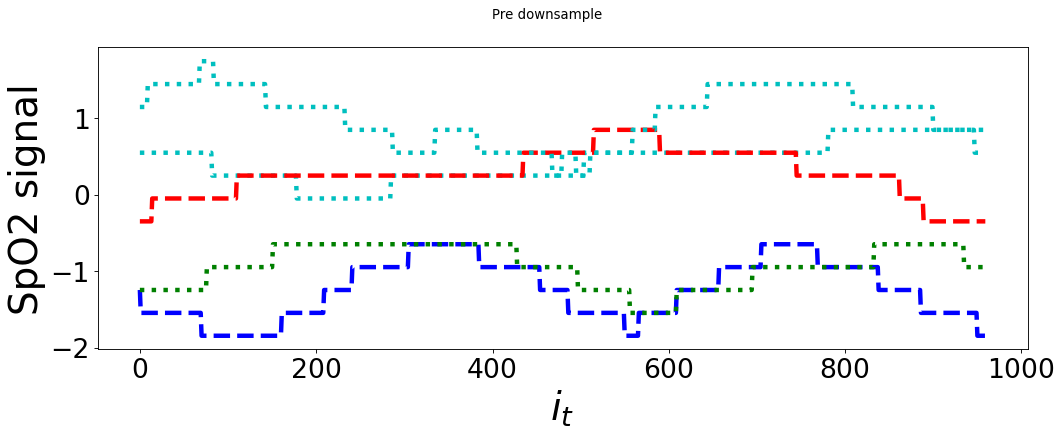

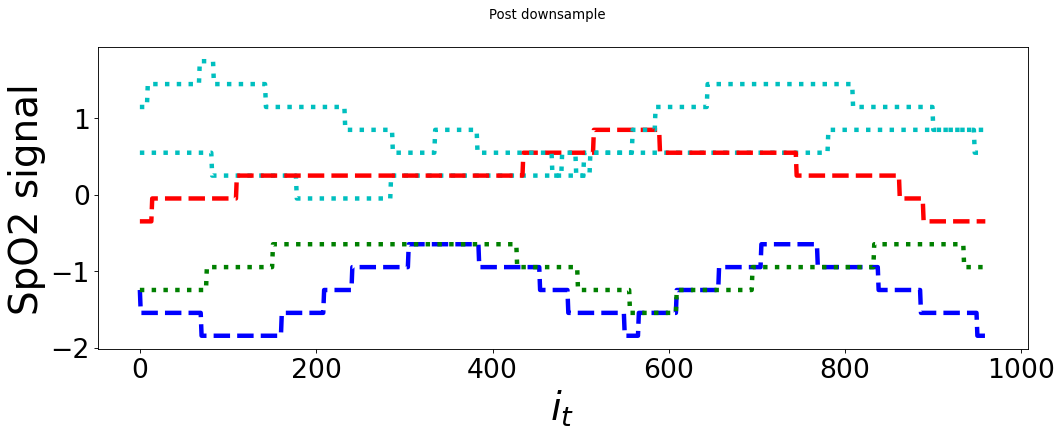

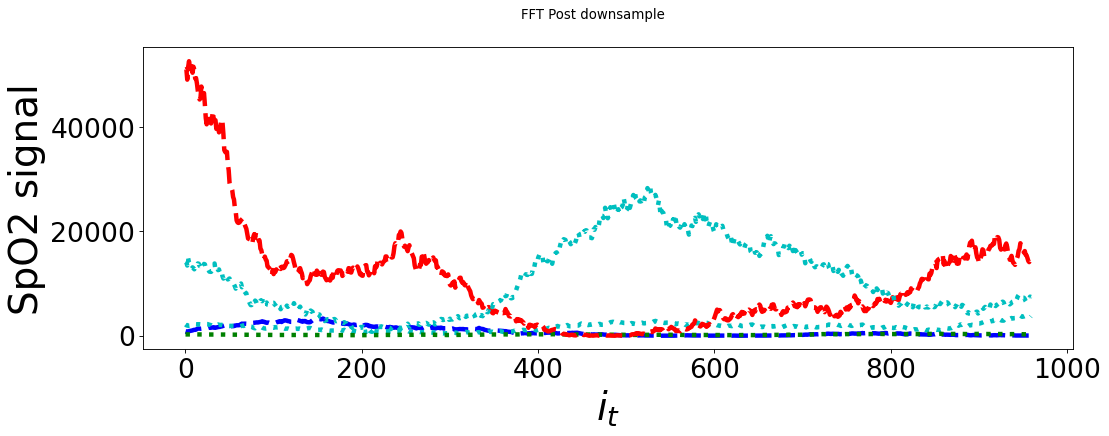

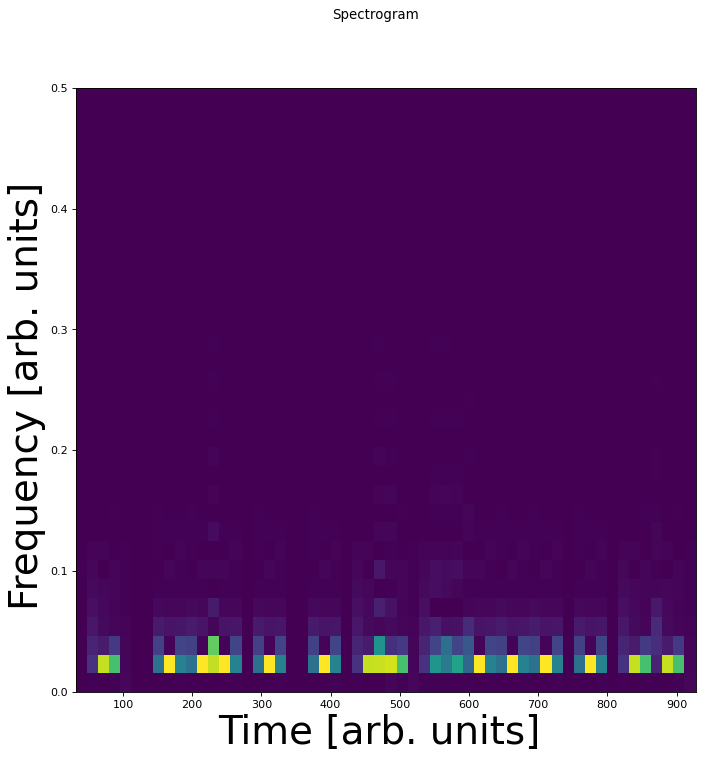

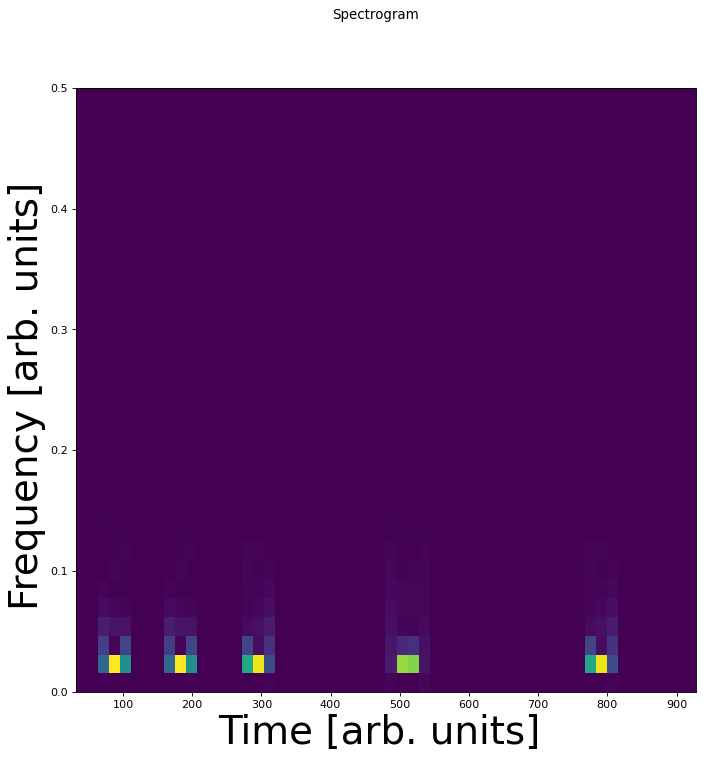

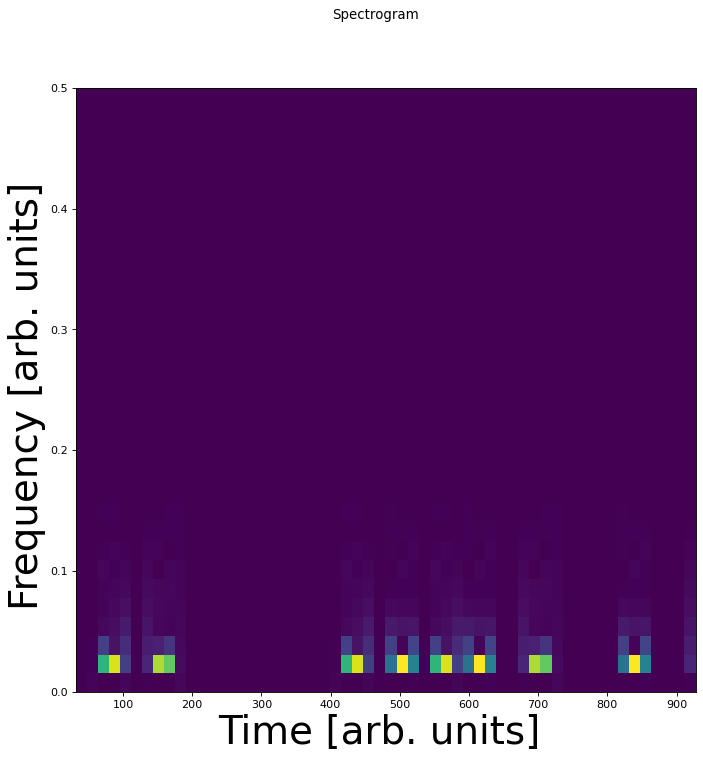

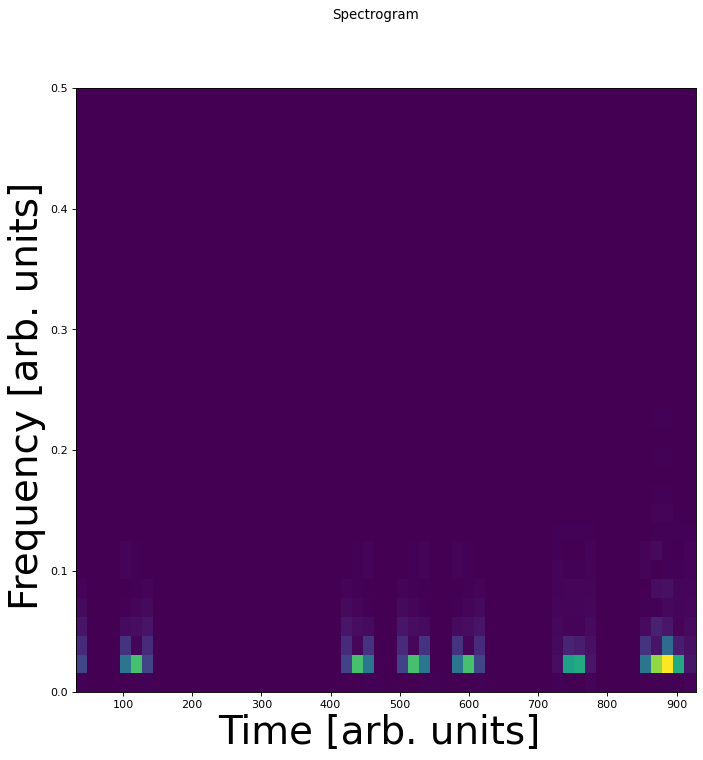

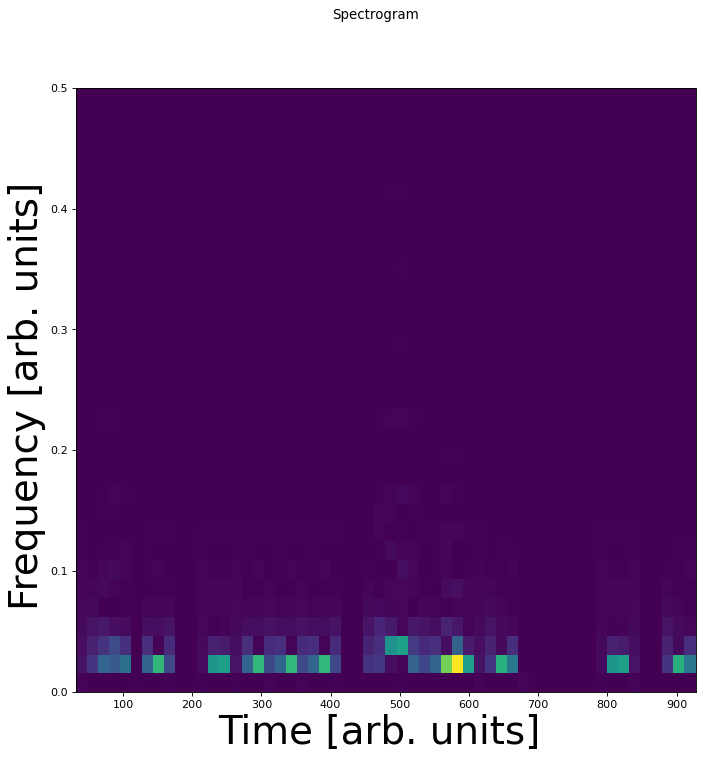

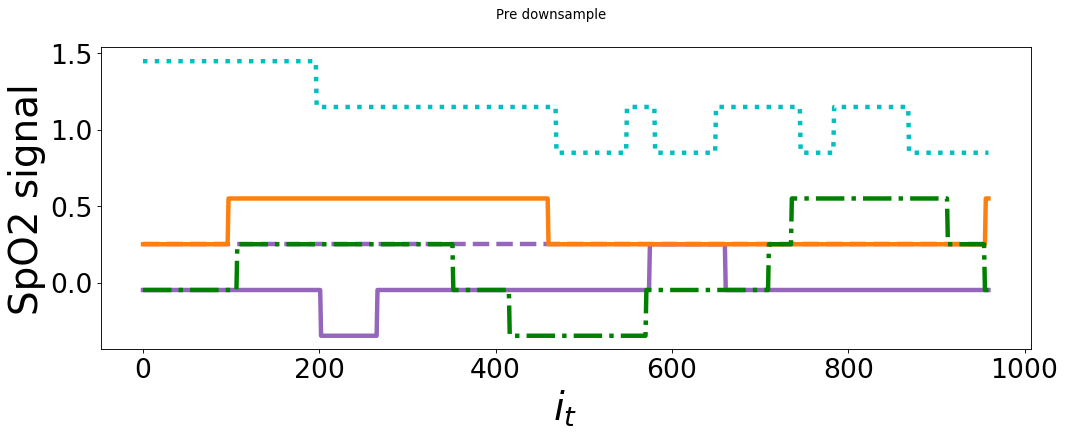

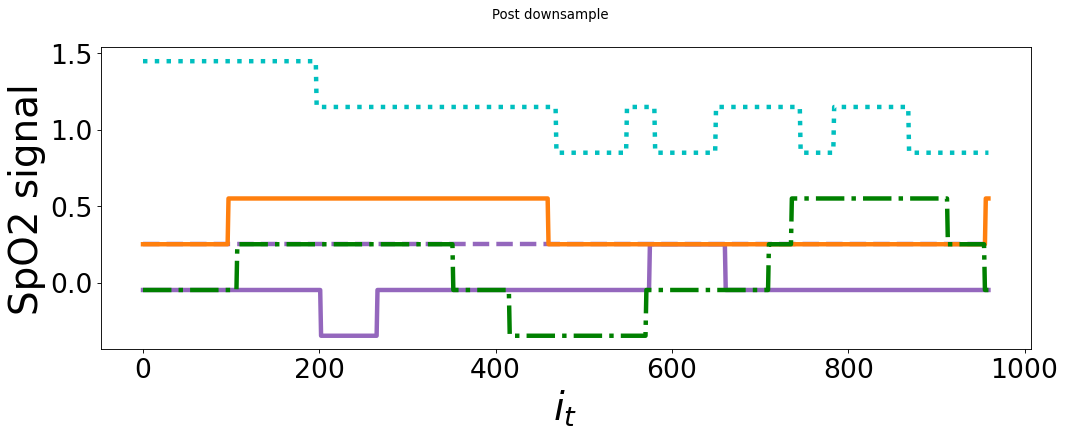

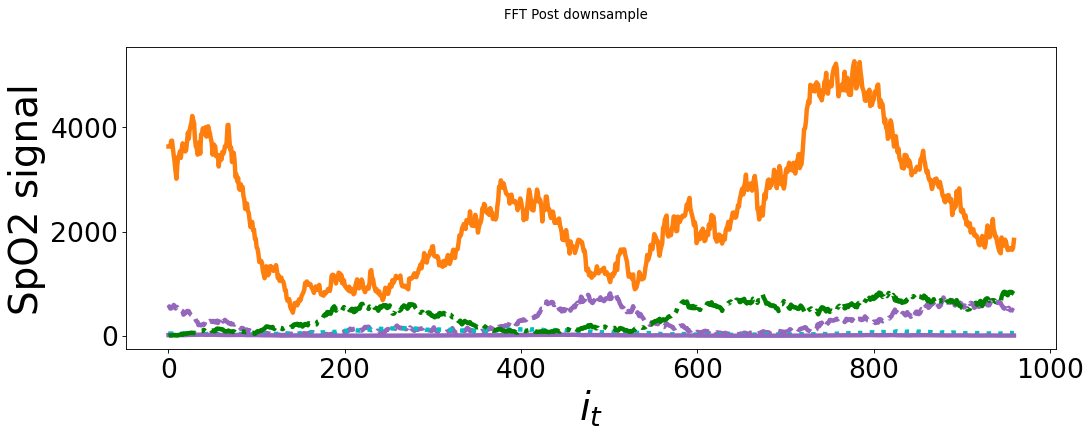

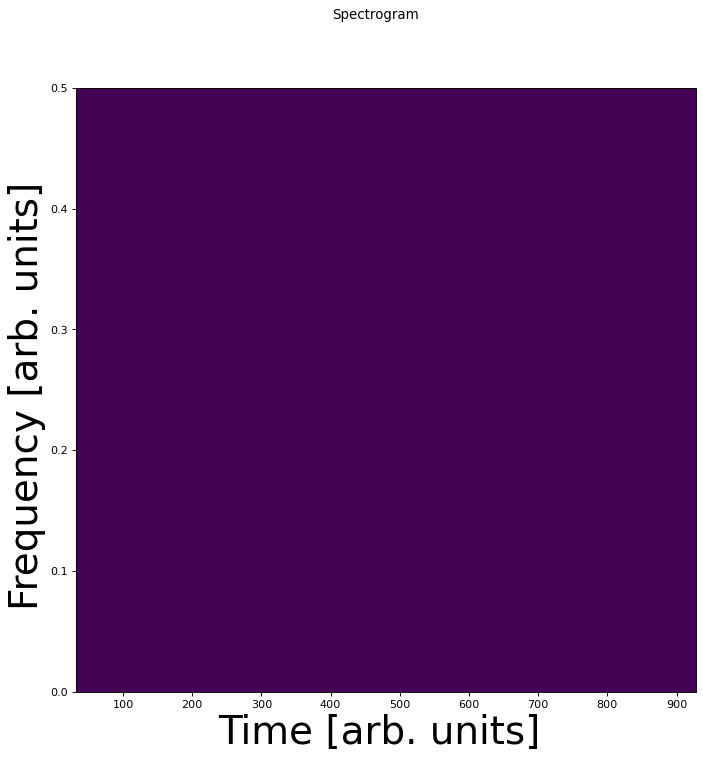

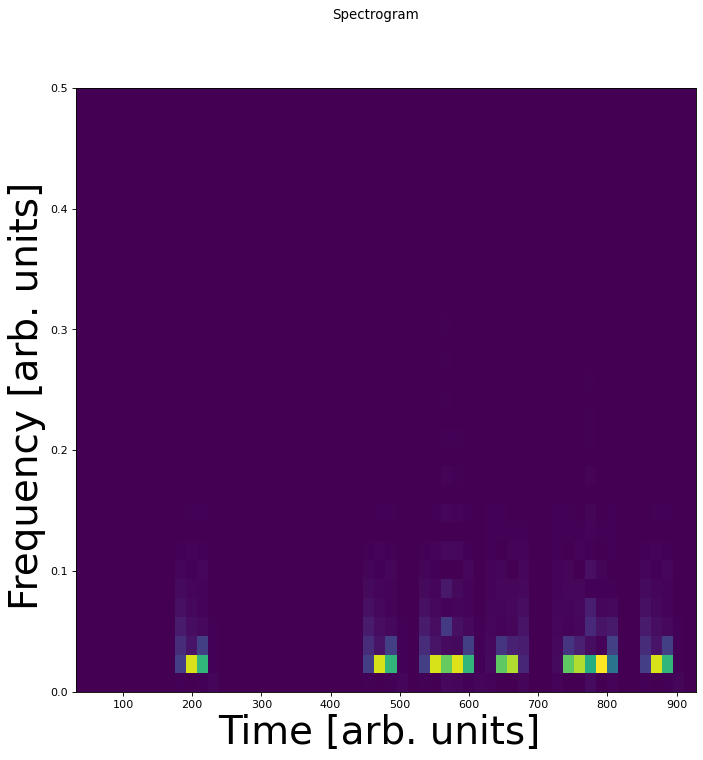

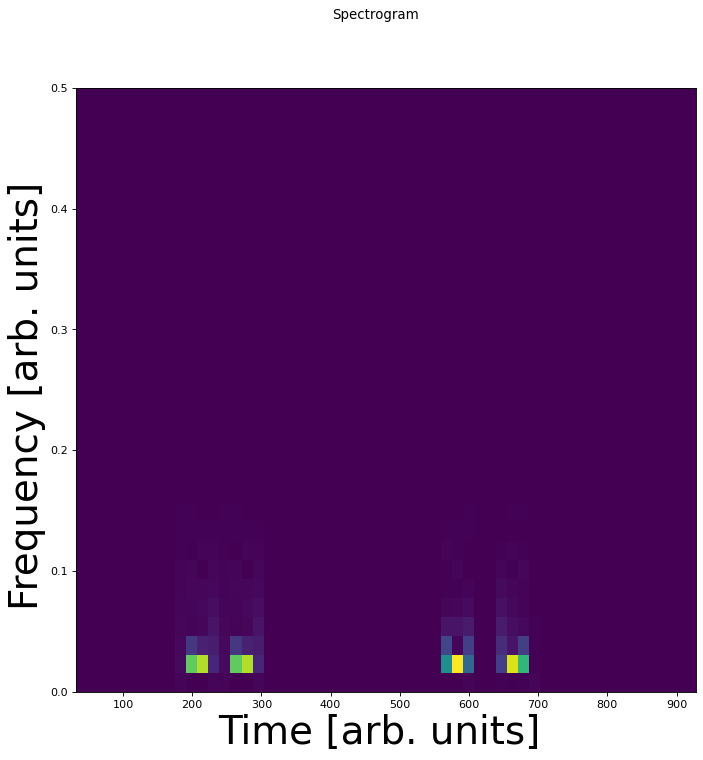

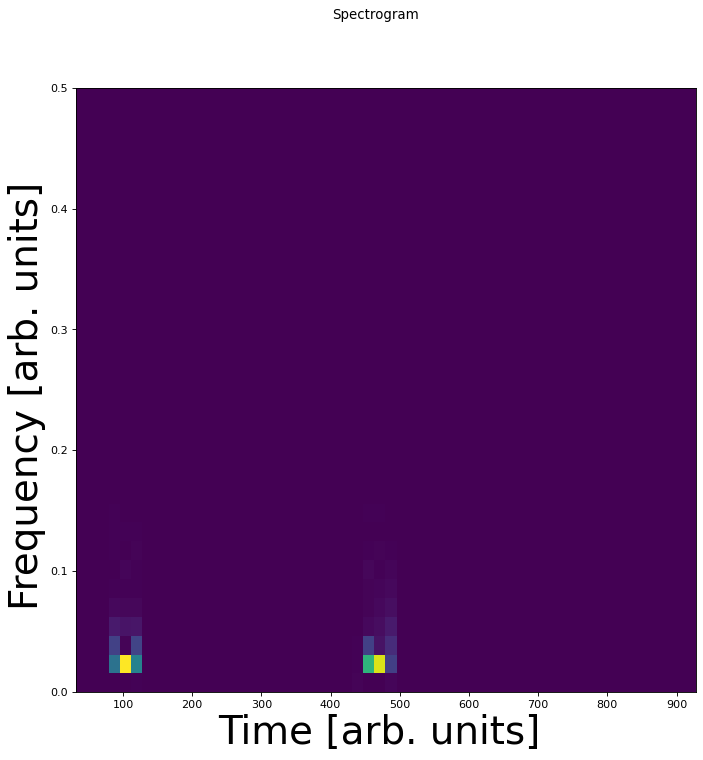

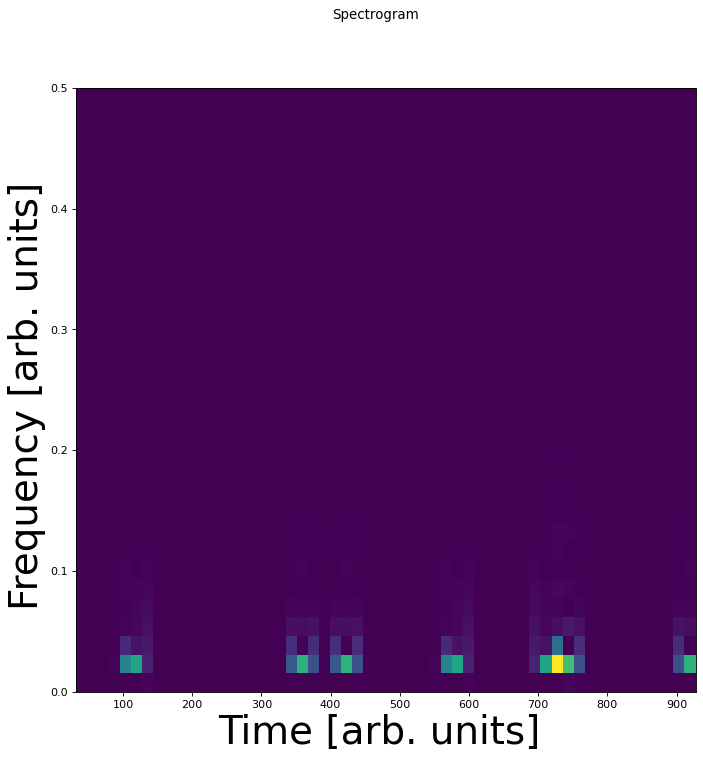

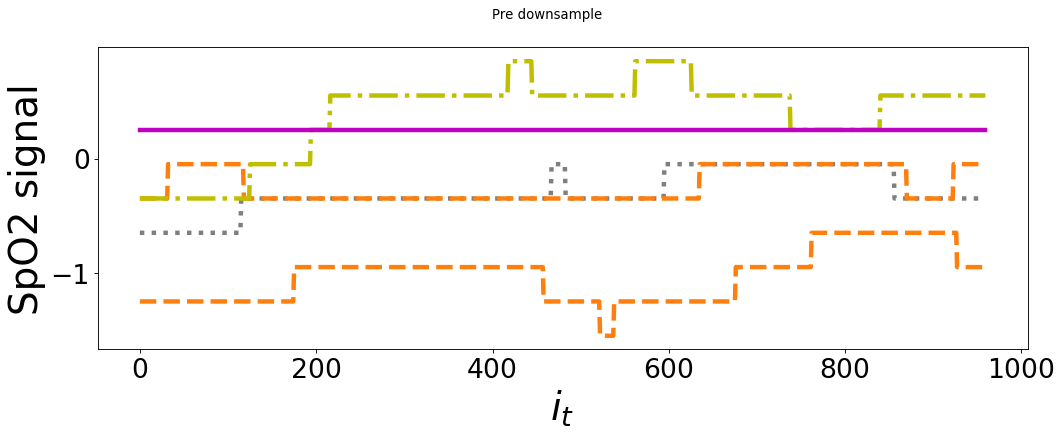

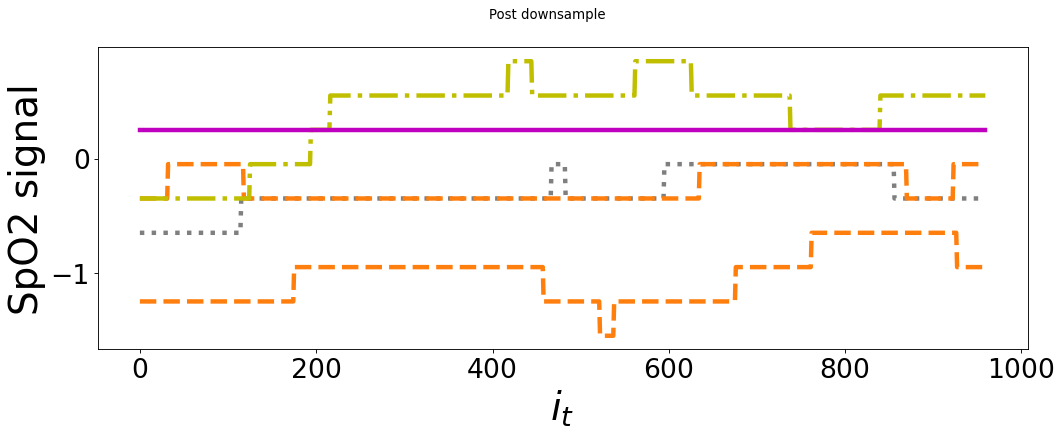

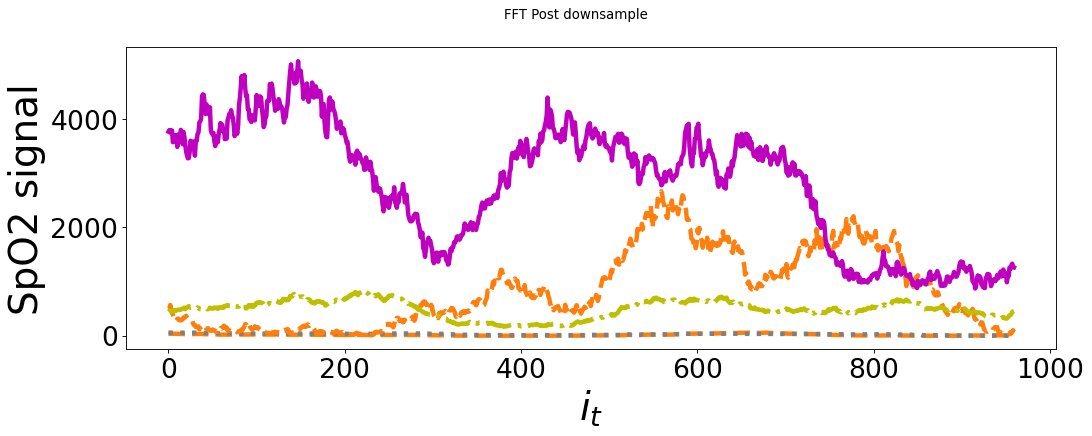

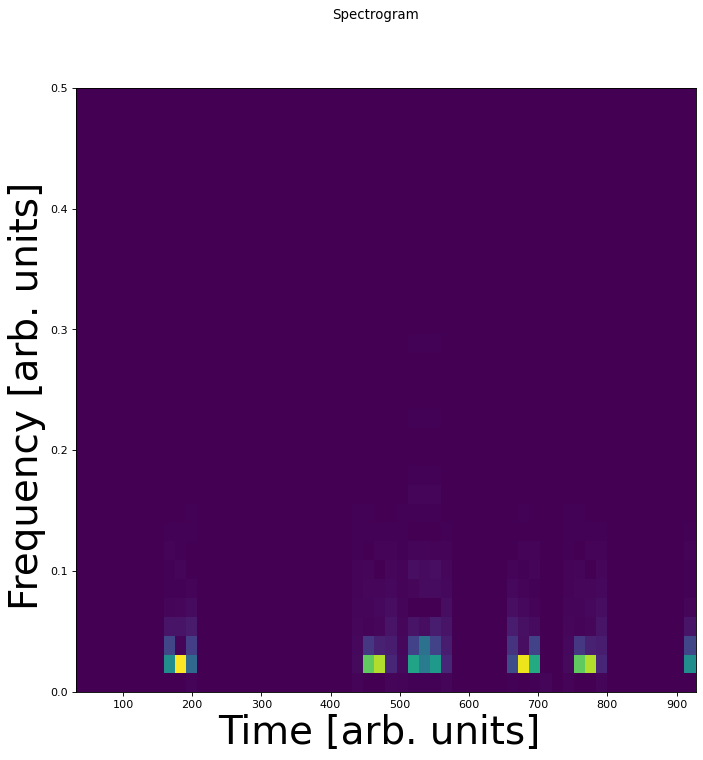

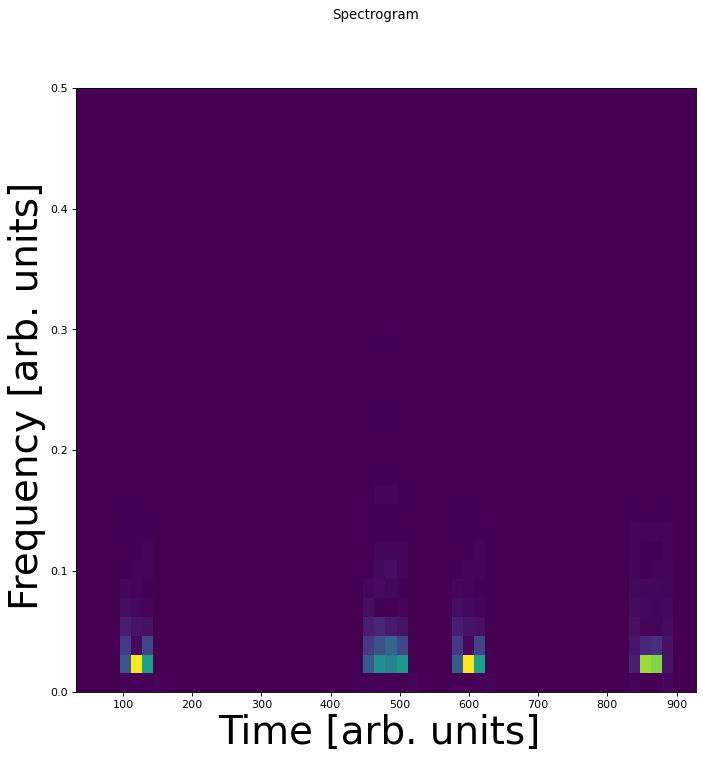

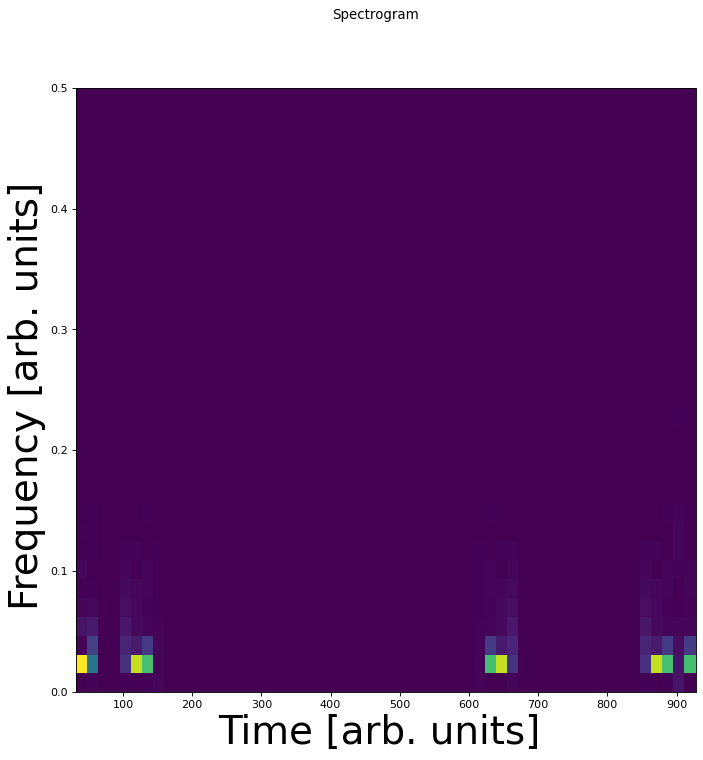

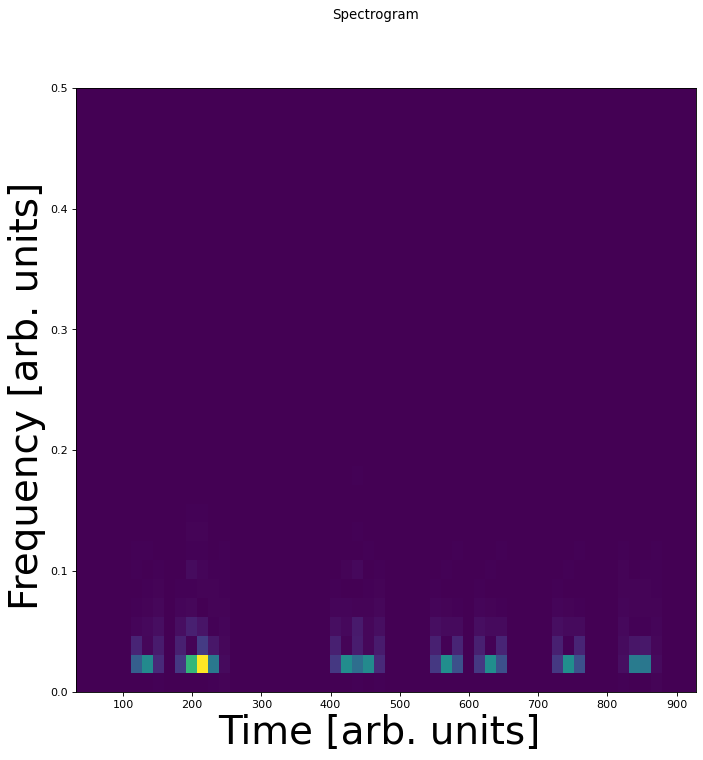

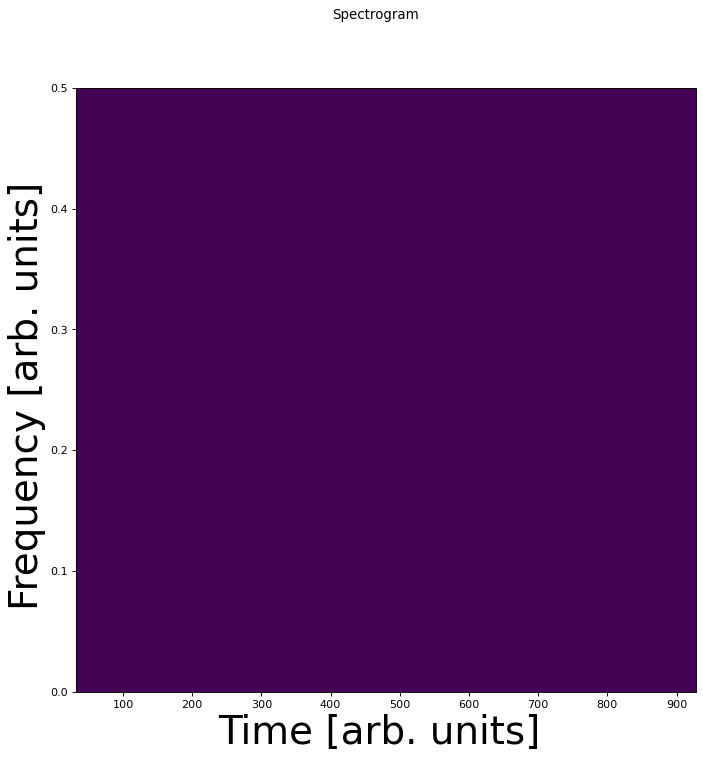

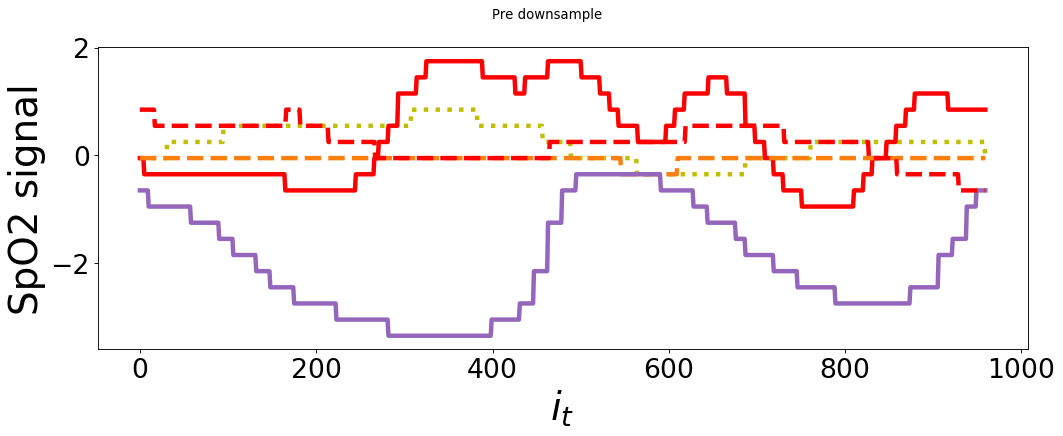

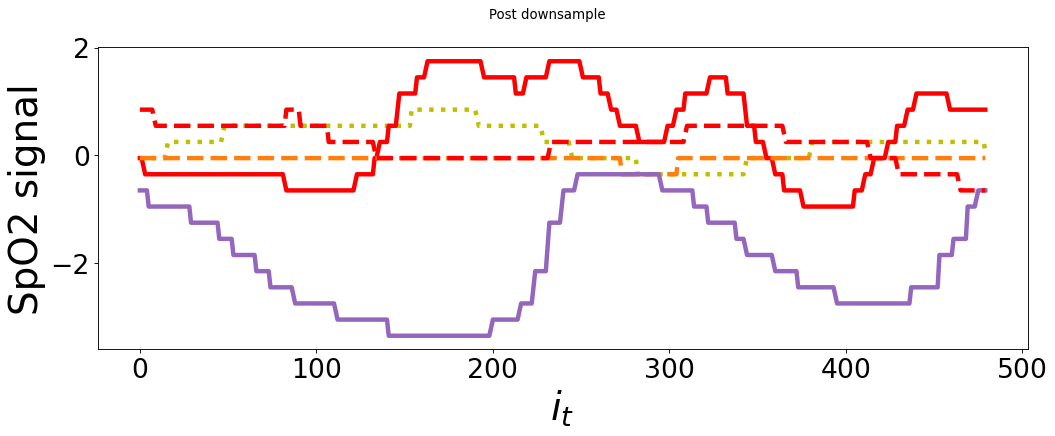

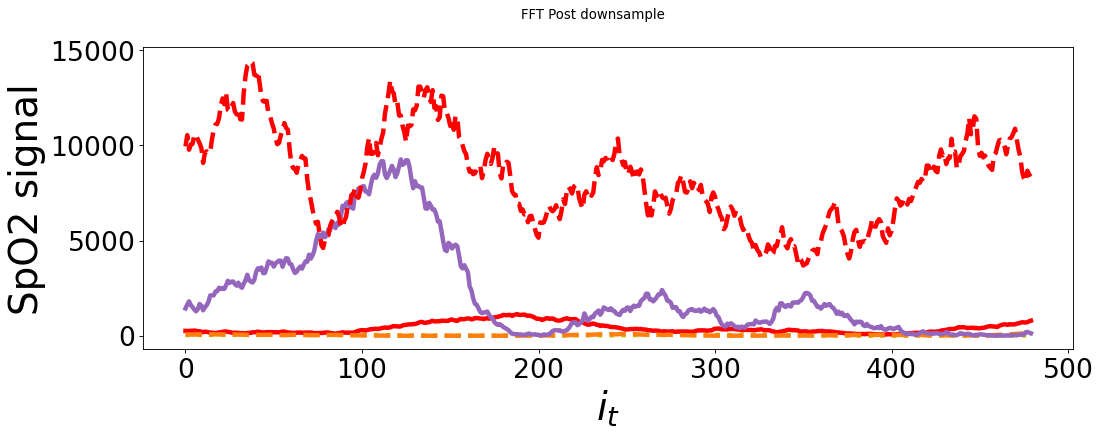

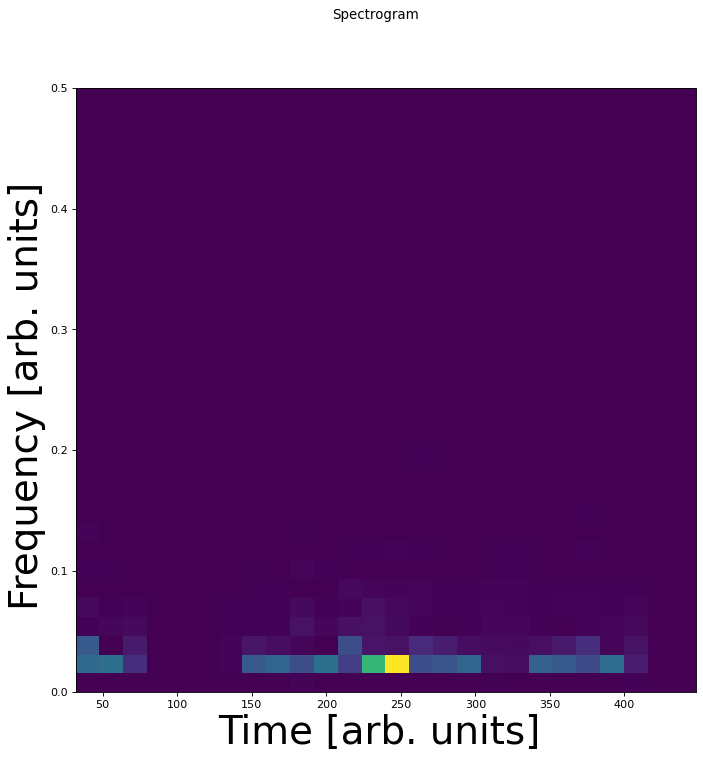

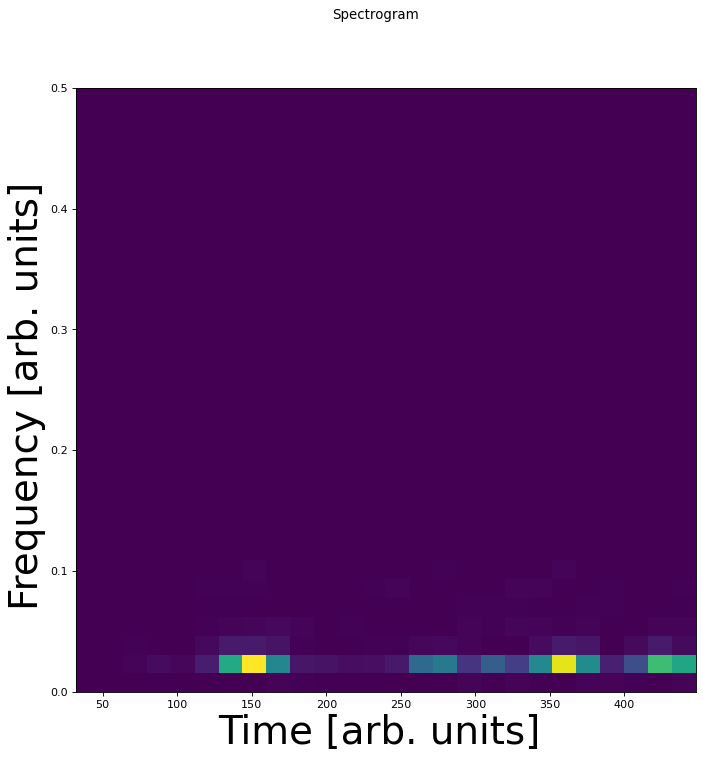

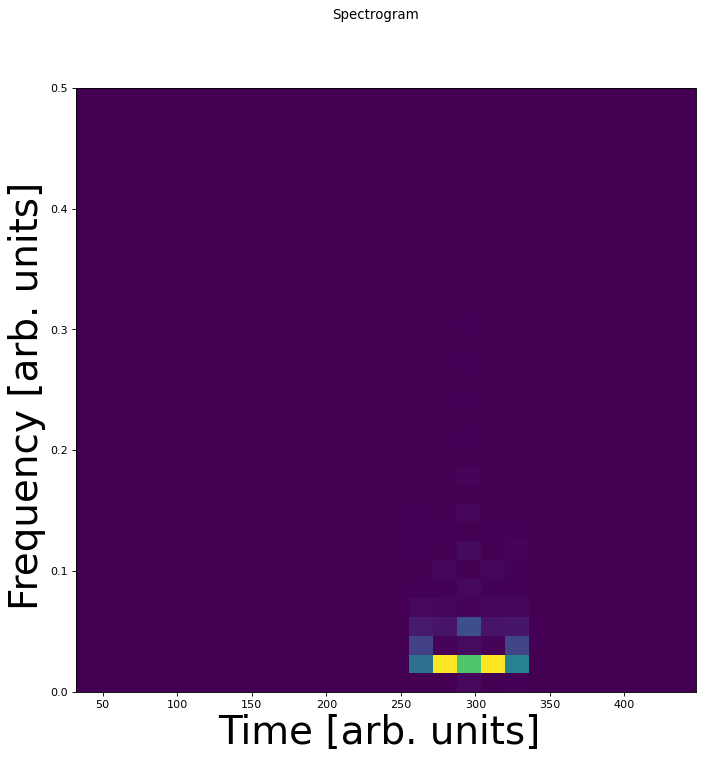

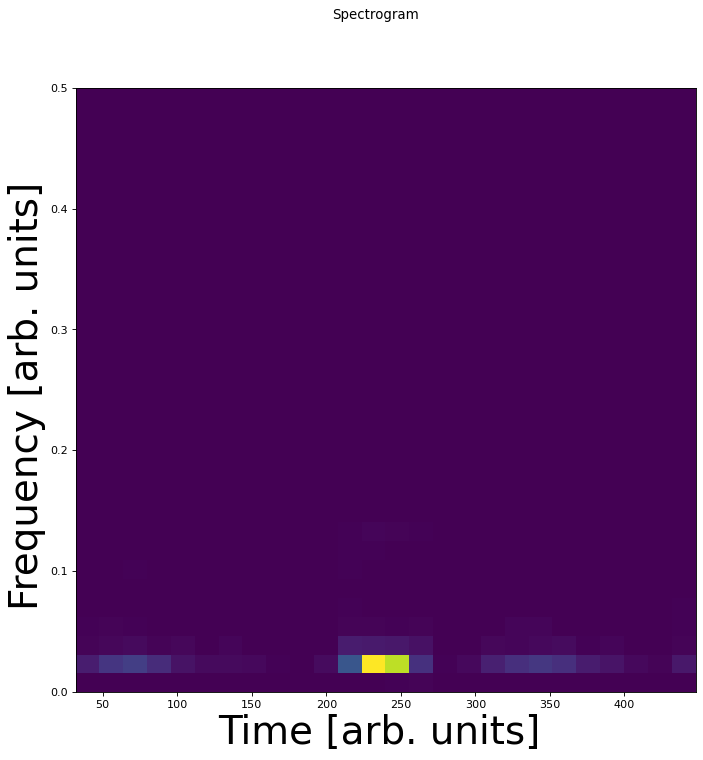

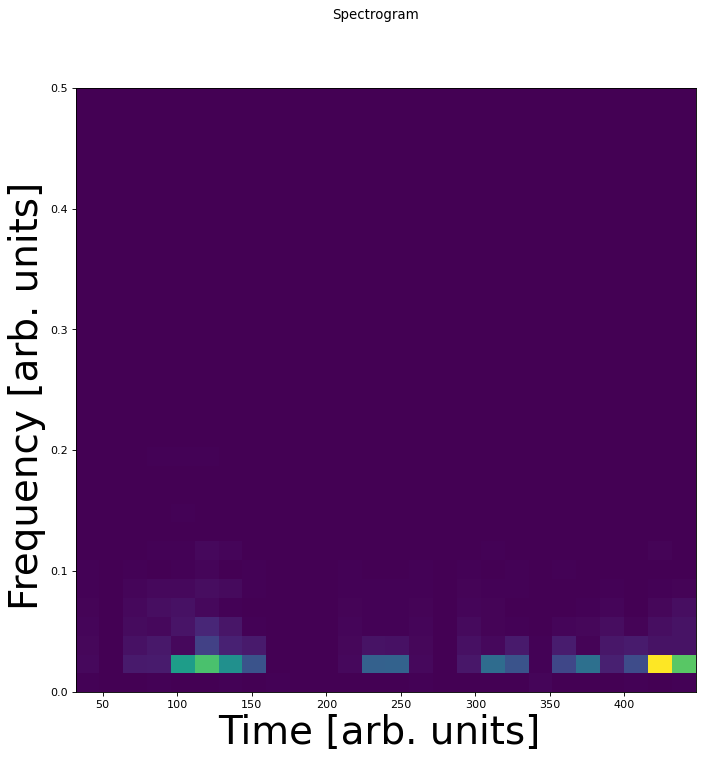

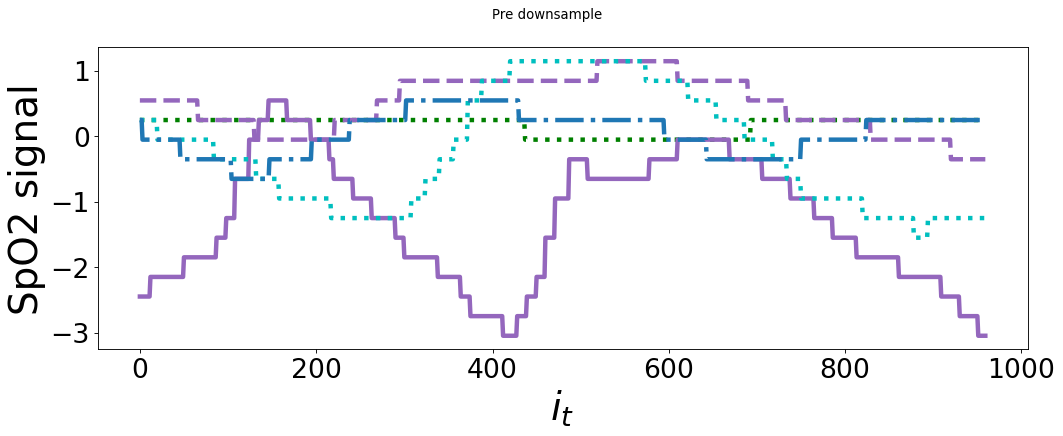

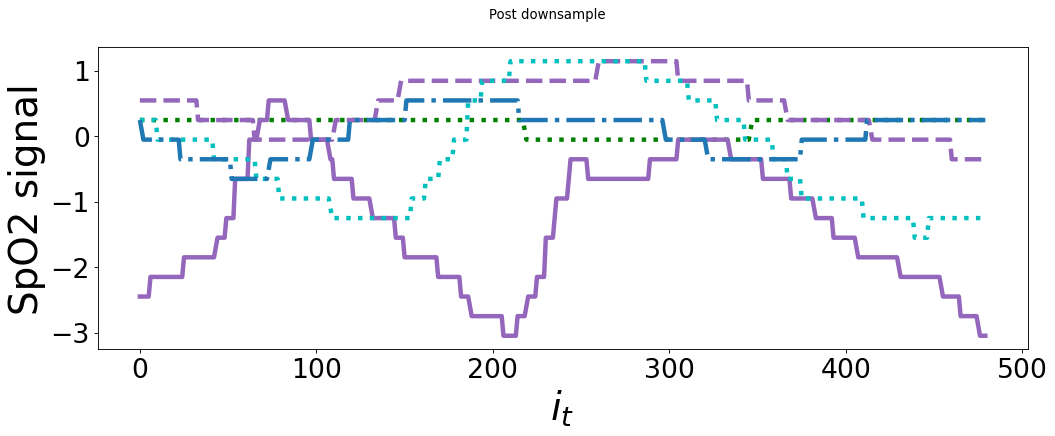

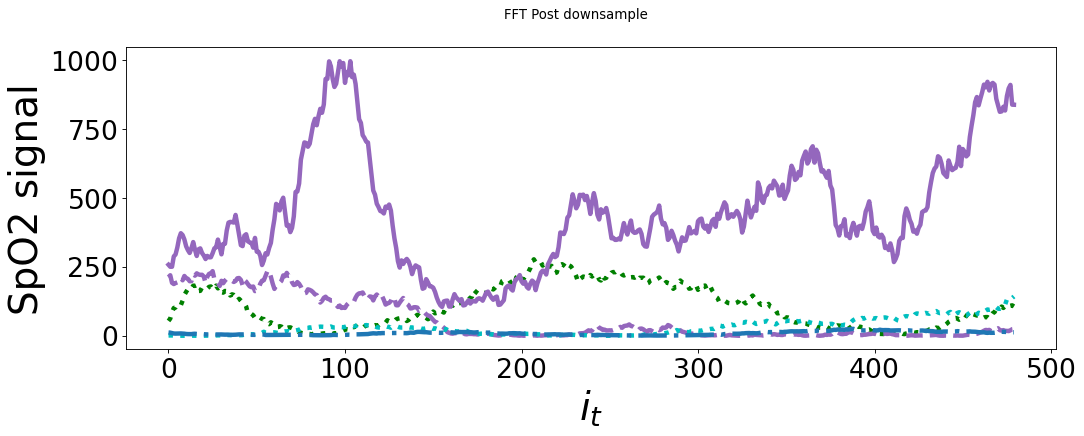

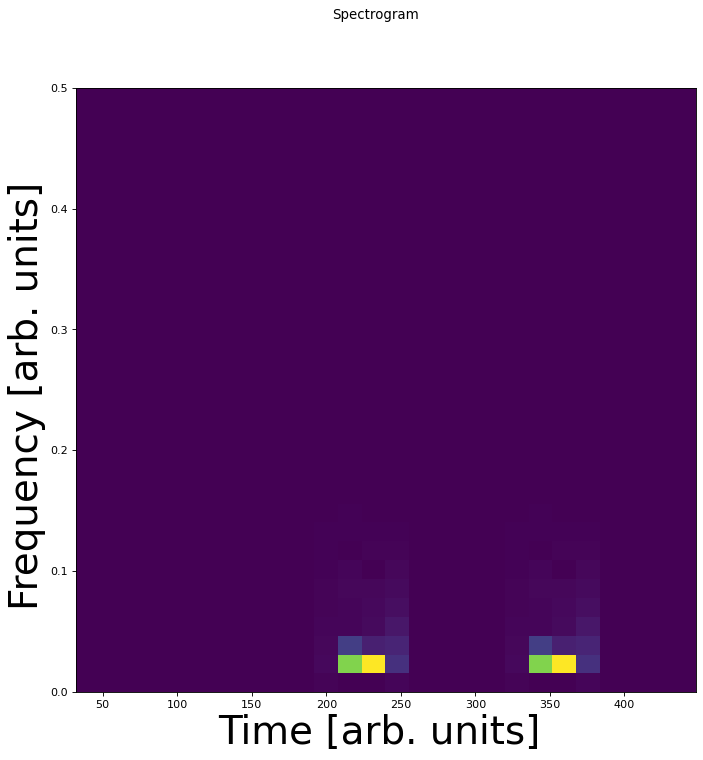

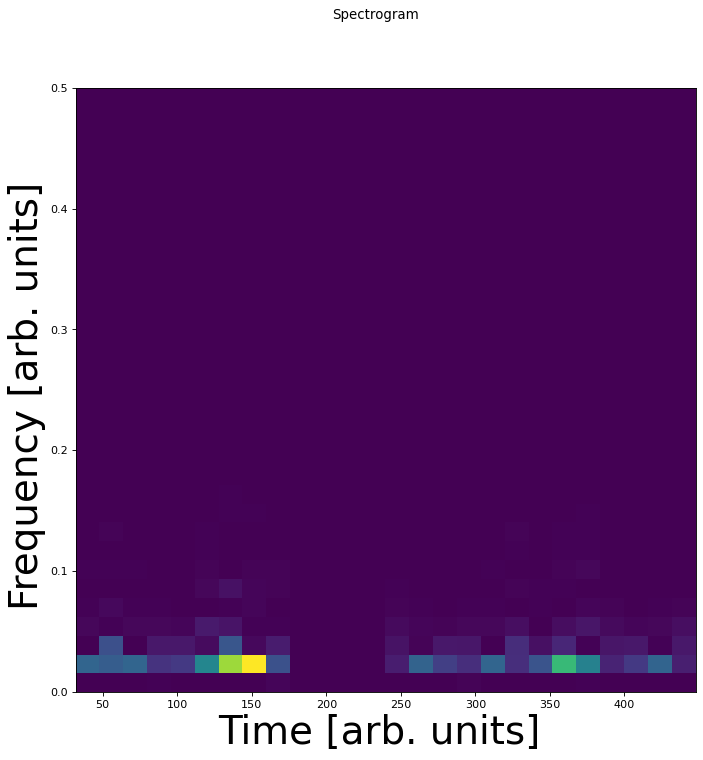

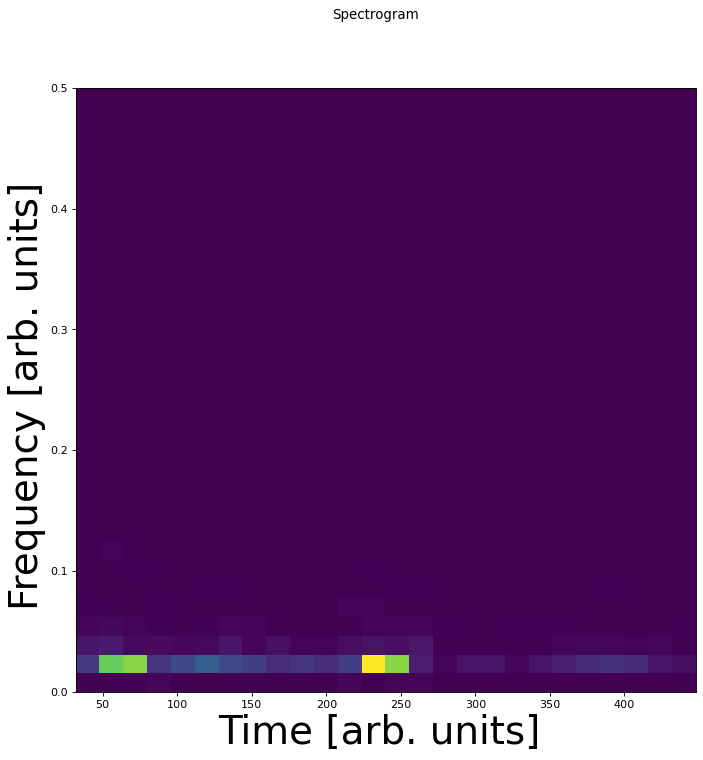

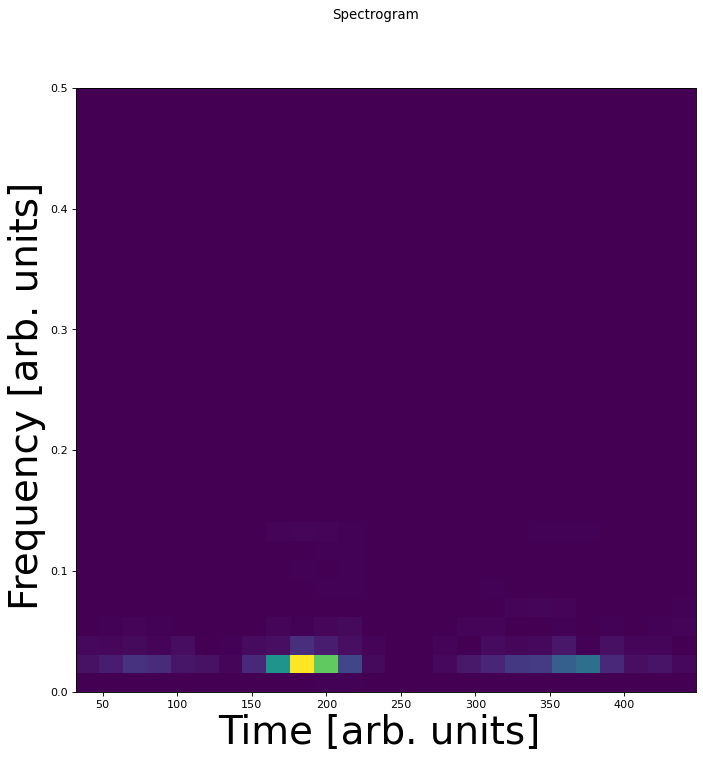

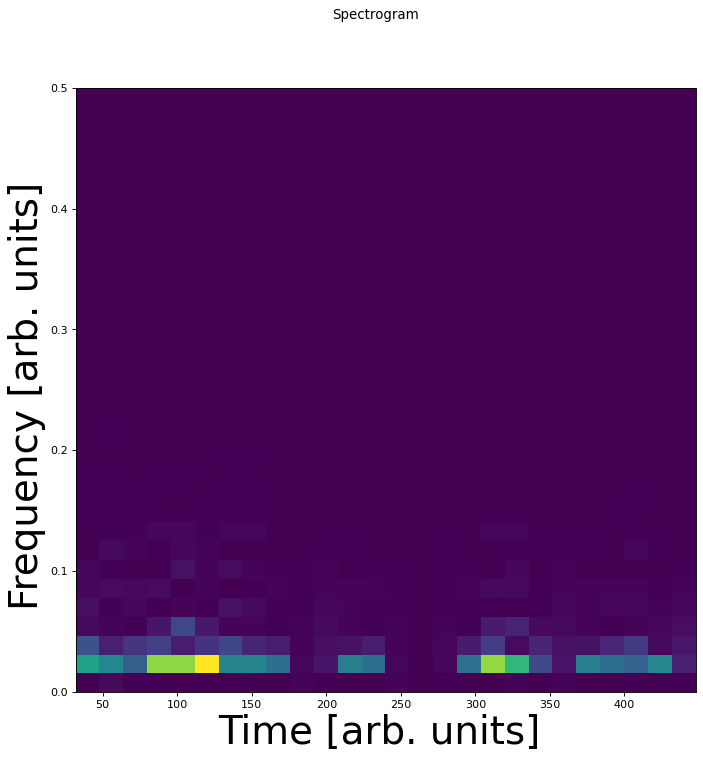

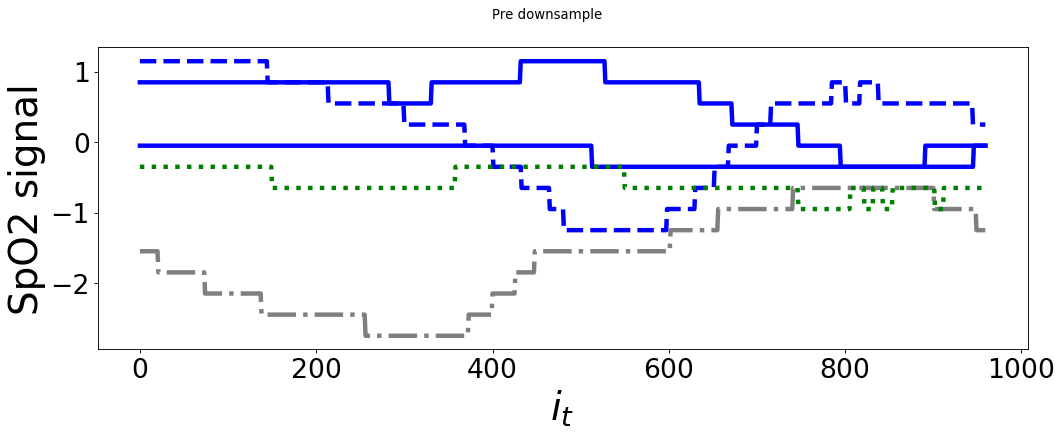

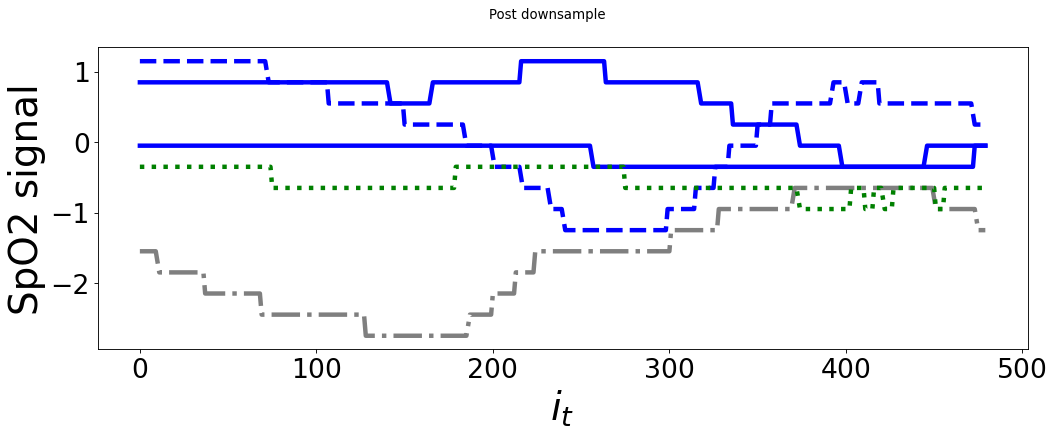

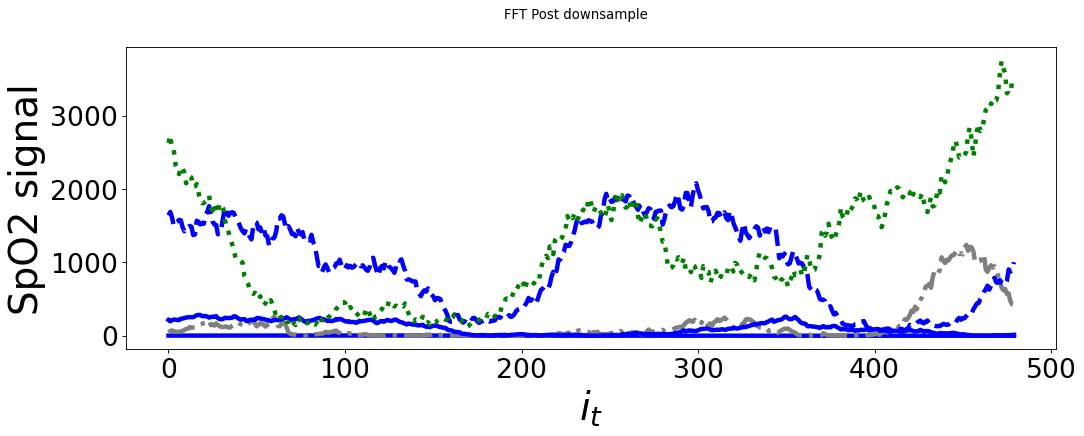

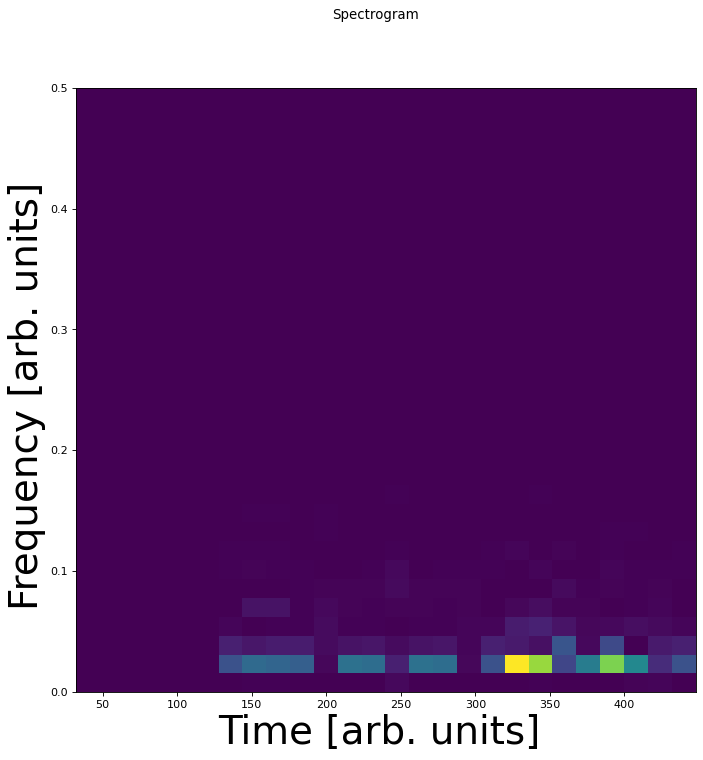

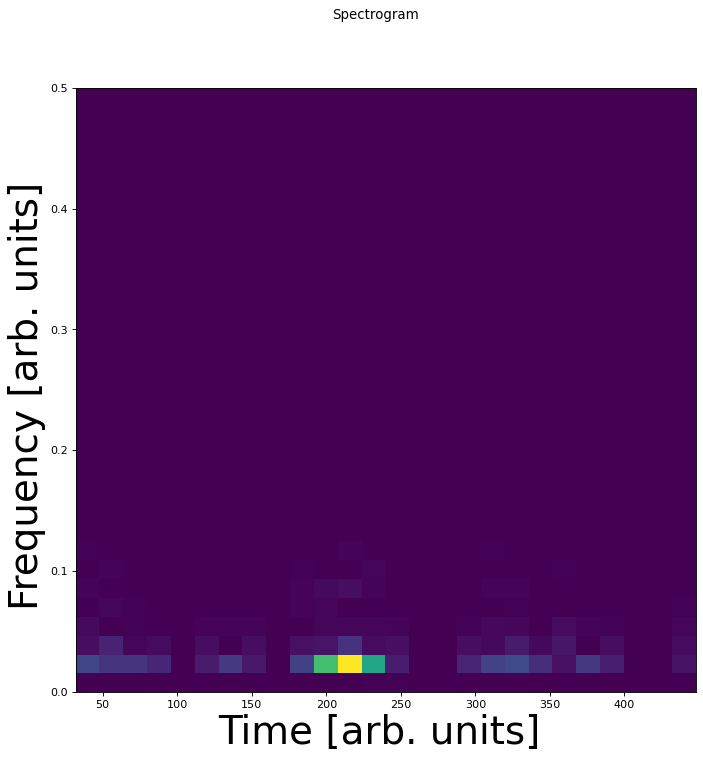

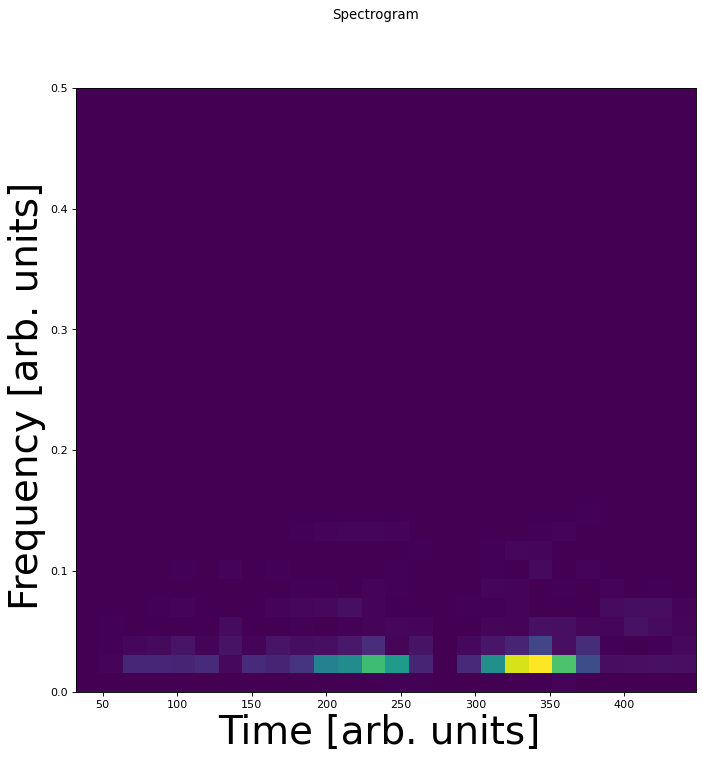

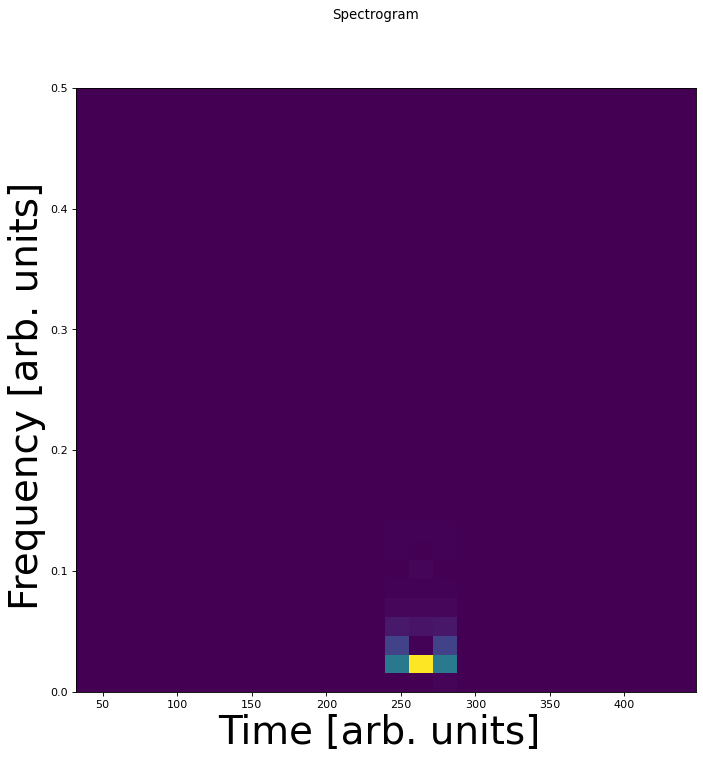

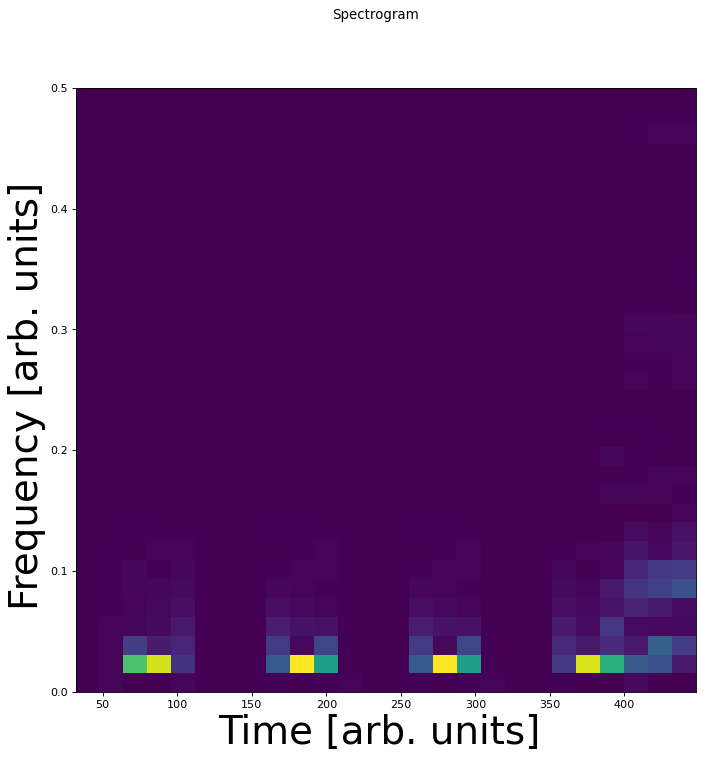

In [12]:
#trainDF=featured_tseries_df("train_SpO2seg.csv",downsample=4)
#valDF=featured_tseries_df("val_SpO2seg.csv",downsample=4)
#testDF=featured_tseries_df("test_SpO2seg.csv",downsample=4)
 

TSdsp1=TimeSeriesBundle("TSdsp1","../DatosOriginales/train_SpO2seg.csv",\
                        "../DatosOriginales/val_SpO2seg.csv",\
                        "../DatosOriginales/test_SpO2seg.csv",\
            downsample=1,augment=1,diff=0)
TSdsp2=TimeSeriesBundle("TSdsp2","../DatosOriginales/train_SpO2seg.csv",\
                        "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
            downsample=2,augment=1,diff=0)
#TSdsp4=TimeSeriesBundle("TSdsp4","../DatosOriginales/train_SpO2seg.csv",\
#                        "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
#            downsample=4,augment=1,diff=0)
#TSdsp8=TimeSeriesBundle("TSdsp8","../DatosOriginales/train_SpO2seg.csv",\
#                        "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
#            downsample=8,augment=1,diff=0)
#TSdsp16=TimeSeriesBundle("TSdsp16","../DatosOriginales/train_SpO2seg.csv",\
#                         "../DatosOriginales/val_SpO2seg.csv","../DatosOriginales/test_SpO2seg.csv",\
#            downsample=16,augment=1,diff=0)




In [13]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D,Flatten,Dense, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras.layers import BatchNormalization,LayerNormalization
from keras.layers import LeakyReLU, Activation, LSTM, AveragePooling1D
#from keras_visualizer import visualizer
import keras
from keras import Input

### PAra solucionar prob de compatibilidad con cuCNN
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from keras import backend as K

import tensorflow as tf

class NewSequentialModelazos2D():
    def __init__(self,BundleObj,modelname,nfiltLs,nbinsLs,nstrideLs,npoolLs,batchsize=20,epochs=15,learningR=0.01):
    
        self.model = Sequential() ## inicializamos un objeto de la clase Sequential
        
        assert(isinstance(BundleObj,TimeSeriesBundle)) ### check de que se trate de un objeto de la clase Bundle.
        self.BundleObj=BundleObj
        self.nline,self.nf,self.nt,self.nchan=np.shape(BundleObj.Train.SpecGram)    
        self.ncols=np.shape(BundleObj.Train.labeltab)[1]
        print("Train labeltab spread:", np.sum(self.BundleObj.Train.labeltab,axis=0))
        self.modelname=modelname
        self.nfiltLs=nfiltLs
        self.nbinsLs=nbinsLs
        self.npoolLs=npoolLs
        self.nstrideLs=nstrideLs
        self.batchsize=batchsize
        self.epochs=epochs
        #self.
        self.opti=keras.optimizers.Adam(learning_rate=learningR)#keras.optimizers.Adam(lr=learningR)

    def model_review(self):
        self.model.summary()
        #visualizer(self.model,format="png",view=True)
        
        
    def setup_model00(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
            strides=(self.nstrideLs[0],self.nstrideLs[0]),input_shape=(self.nf,self.nt,1) ))
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.5))
        #self.model.add(LSTM(128))
        self.model.add(Flatten())
        #self.model.add(Dense( self.nt ) )
        #self.model.add(Activation('relu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        self.model.add(Dense(self.ncols))
        self.model.add(Activation('sigmoid'))
        self.model_review()
        self.model.compile(loss='binary_crossentropy',optimizer=self.opti,metrics=['accuracy'])
                #### categorical_crossentropy
    def setup_model01(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
            strides=(self.nstrideLs[0],self.nstrideLs[0]),input_shape=(self.nf,self.nt,1) ))
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        #self.model.add(AveragePooling1D( pool_size=(self.npoolLs[0],self.npoolLs[0]) ) )
        
        ## intermedio
        for inb,nb in enumerate(self.nbinsLs[1:],1):
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb), strides=(self.nstrideLs[inb],self.nstrideLs[inb])))
            self.model.add(Activation('selu'))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb) ))
            self.model.add(Activation('selu'))
            #self.model.add(AveragePooling2D( pool_size=(self.npoolLs[inb],self.npoolLs[inb]) ))
        self.model.add(Flatten())
        #self.model.add(Dense( 10*int(np.sqrt(self.nt)),activation='relu'))
        self.model.add(Dense( self.nt)) 
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        self.model.add(Dense(self.ncols )) #,activation='sigmoid'))
        self.model.add(Activation('sigmoid'))
        self.model_review()
        self.model.compile(loss='categorical_crossentropy',optimizer=self.opti,metrics=['accuracy'])
    
    def setup_model02(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]) ,\
            strides=self.nstrideLs[0],input_shape=(self.nf,self.nt,1) ))#,activation='relu'))
        self.model.add(Activation('selu'))
        self.model.add(LeakyReLU(alpha=0.05))
        #self.model.add(AveragePooling2D( pool_size=(self.npoolLs[0],self.npoolLs[0]) ) )

        ## intermedio
        for inb,nb in enumerate(self.nbinsLs[1:],1):
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb), strides=(self.nstrideLs[inb],self.nstrideLs[inb]) )) # ,activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.05))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb) )) #, activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.05))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb) )) #, activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(AveragePooling2D(pool_size=(self.npoolLs[inb],self.npoolLs[inb]) ))
        self.model.add(Flatten())
        self.model.add(Dense( self.nt)) 
        self.model.add(Activation('selu'))
        self.model.add(Dense(self.ncols )) #,activation='sigmoid'))
        self.model.add(Activation('sigmoid'))
        self.model_review()
        self.model.compile(loss='categorical_crossentropy',optimizer=self.opti,metrics=['accuracy'])
        
        
    def setup_model03(self):
        #assert(isinstance(GalleryObj,Gallery))

        ## entrada
        self.model.add(Conv2D(self.nfiltLs[0], (self.nbinsLs[0],self.nbinsLs[0]),\
            strides=(self.nstrideLs[0],self.nstrideLs[0]),input_shape=(self.nf,self.nt,1))) # ,activation='relu'))
        self.model.add(Activation('selu'))
        #self.model.add(LeakyReLU(alpha=0.05))
        #self.model.add(MaxPool2D( pool_size=(self.npoolLs[0],self.npoolLs[0]) ) )
        ## intermedio
        for inb,nb in enumerate(self.nbinsLs[1:],1):
                       
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb), strides=(self.nstrideLs[inb],self.nstrideLs[inb]) )) #,activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.05))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb) ))#, activation='relu'))
            self.model.add(Activation('selu'))
            #self.model.add(LeakyReLU(alpha=0.1))
            self.model.add(Dropout(0.10))
            self.model.add(Conv2D(self.nfiltLs[inb], (nb,nb) )) #, activation='relu'))
            #self.model.add(MaxPool2D(pool_size=(self.npoolLs[inb],self.npoolLs[inb]) ))
        self.model.add(Flatten())
        #self.model.add(Dense(10* int(np.sqrt(self.nt)),activation='relu'))
        self.model.add(Dense(self.ncols )) #,activation='sigmoid'))  ### "softmax","sigmoid"
        self.model.add(Activation('sigmoid'))
        self.model_review()
        
        self.model.compile(loss='categorical_crossentropy',optimizer=self.opti,metrics=['accuracy'])
 

        
    def run_model(self):
        print("Val labeltab spread:", np.sum(self.BundleObj.Val.labeltab,axis=0))
        self.history=self.model.fit(self.BundleObj.Train.SpecGram, self.BundleObj.Train.labeltab,
              batch_size=self.batchsize,
              epochs=self.epochs,
              validation_data=(self.BundleObj.Val.SpecGram, self.BundleObj.Val.labeltab))

        #model0.summary()
        #print(self.history.history.keys())
        #return model0,history0
        
    def plot_history(self):
        histDF=pd.DataFrame(self.history.history)
        histDF["epoch"]=self.history.epoch

        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle("Training and Validation Loss")
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('Epoch ', fontsize = 35)
        ax1.set_ylabel('Loss function', fontsize = 35)
        ax4.set_xlabel('Epoch ', fontsize = 35)
        ax4.set_ylabel('Loss function', fontsize = 35)  
        #plt.figure()
        #plt.xlabel("Epoch")
        #plt.ylabel("Loss function" )
        ax1.plot(histDF["epoch"],histDF["loss"],"r--",label="Training Loss")
        ax1.plot(histDF["epoch"],histDF["val_loss"],"b-.",label="Validation Loss")

        #plt.ylim([0,0.5])
        ax1.legend()
        plt.show()
        plt.savefig("Loss_"+self.modelname+"_"+ \
                    self.BundleObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        #################################################################
        fig = plt.figure(figsize=(15.0, 5.0), dpi=80)
        fig.set_frameon(False)

        fig.suptitle("Training and Validation Accuracy")
        ax1 = fig.add_subplot(111)
        ax4=fig.add_subplot(111) 
        #ax1.set_ylim(yscale[0],yscale[1])
        #ax1.set_ylim(yscale[0],yscale[1])

        ax1.set_xlabel('Epoch ', fontsize = 35)
        ax1.set_ylabel('Loss function', fontsize = 35)
        ax4.set_xlabel('Epoch ', fontsize = 35)
        ax4.set_ylabel('Accuracy', fontsize = 35)  
        ax1.plot(histDF["epoch"],histDF["accuracy"],"r--",label="Training Acc.")
        ax1.plot(histDF["epoch"],histDF["val_accuracy"],"b-.",label="Validation Acc.")
        ax1.legend()
        #plt.ylim([0,0.5])
        
        plt.show()
        plt.savefig("Acc_"+self.modelname+"_"+ \
                    self.BundleObj.name+"_"+".png", bbox_inches='tight', dpi=100)
        
    def predict(self):
         self.pred= np.argmax(self.model.predict(self.BundleObj.Test.SpecGram),axis=-1)

    def make_confusion_mat(self,TestTrue):
        pass
        self.results={}
        ###self.confmat=confusion_matrix(dfObj.y_trainval , ypre )
        self.confmat=pd.crosstab(TestTrue,self.pred  )
        self.confmatNP=self.confmat.to_numpy()
        truetrue=np.sum(np.diagonal(self.confmatNP ))
        accu=truetrue/np.sum(self.confmatNP )
        print("Test Accuracy :", accu)
        print(self.confmat)
        self.TestTrue=TestTrue
        #recall=
        self.results["accu"]=accu
        self.results["recall"]=self.confmatNP[1,1] /np.sum(self.confmatNP[1,:])
        self.results["specif"]=self.confmatNP[0,0] /np.sum(self.confmatNP[0,:]) 
        self.results["ppv"]=self.confmatNP[1,1] /np.sum(self.confmatNP[:,1])
        self.results["npv"]=self.confmatNP[0,0] /np.sum(self.confmatNP[:,0]) 
        
        
        
        
        fig = plt.figure(figsize=(5.0, 5.0), dpi=80)
        plt.clf()
        ax = fig.add_subplot(111)
        ax.set_aspect(1)
        #self.confmat.pivot("True label", "Predicted label", "N")
        res = sn.heatmap( self.confmat, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
        res.set_xlabel("Predicted label")
        res.set_ylabel("True label")
        plt.savefig("confmat_"+self.modelname+"_"+self.BundleObj.name+"_"+".png",\
                    bbox_inches='tight', dpi=100)
        plt.show()
    
    

/home/billybob/anaconda3/envs/NewDS38/lib/python3.8/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2216650507967585052
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3573911419458818354
physical_device_desc: "device: XLA_CPU device"
]
Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model00
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 55, 15)        150       
_________________________________________________________________
activation (Activation)      (None, 31, 55, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25575)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 51152     
_____________________

Epoch 49/60
24/24 [==============================] - 0s 20ms/step - loss: 0.6588 - accuracy: 0.6154 - val_loss: 0.6800 - val_accuracy: 0.5660
Epoch 50/60
24/24 [==============================] - 1s 21ms/step - loss: 0.6594 - accuracy: 0.6137 - val_loss: 0.6803 - val_accuracy: 0.5660
Epoch 51/60
24/24 [==============================] - 1s 22ms/step - loss: 0.6593 - accuracy: 0.6161 - val_loss: 0.6799 - val_accuracy: 0.5660
Epoch 52/60
24/24 [==============================] - 1s 23ms/step - loss: 0.6580 - accuracy: 0.6183 - val_loss: 0.6815 - val_accuracy: 0.5636
Epoch 53/60
24/24 [==============================] - 1s 21ms/step - loss: 0.6580 - accuracy: 0.6189 - val_loss: 0.6799 - val_accuracy: 0.5660
Epoch 54/60
24/24 [==============================] - 0s 20ms/step - loss: 0.6587 - accuracy: 0.6206 - val_loss: 0.6871 - val_accuracy: 0.5600
Epoch 55/60
24/24 [==============================] - 1s 22ms/step - loss: 0.6588 - accuracy: 0.6157 - val_loss: 0.6820 - val_accuracy: 0.5612
Epoch 

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


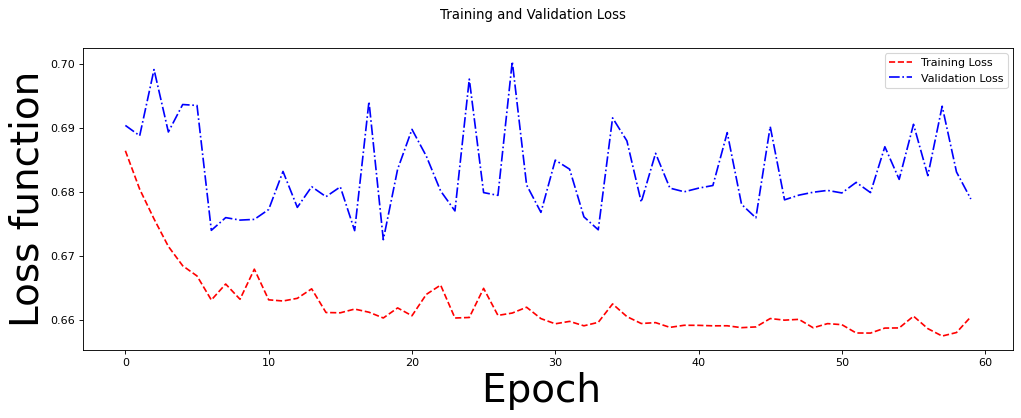

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

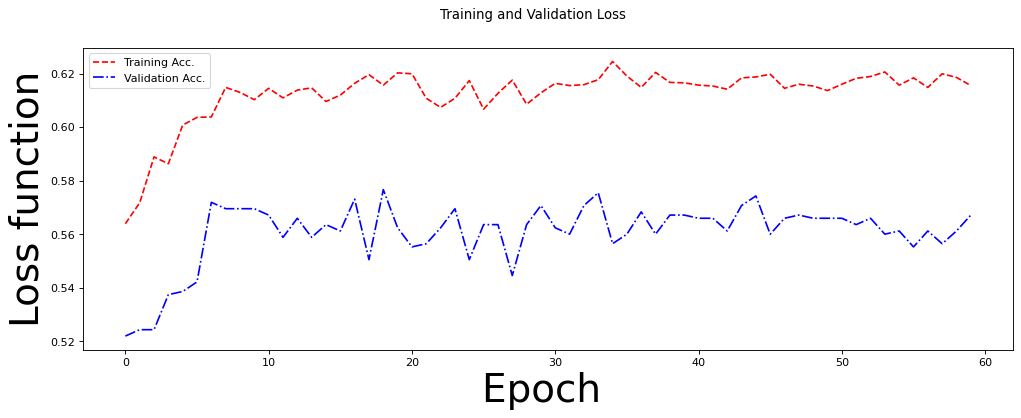

Test Accuracy : 0.5952380952380952
col_0    0    1
row_0          
0      364   60
1      280  136


<Figure size 432x288 with 0 Axes>

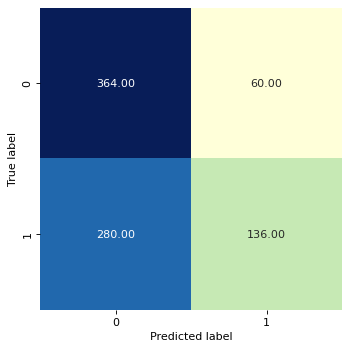

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model01
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 55, 15)        150       
_________________________________________________________________
activation_2 (Activation)    (None, 31, 55, 15)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25575)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 57)                1457832   
_________________________________________________________________
activation_3 (Activation)    (None, 57)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 116       
_______________________________________

Epoch 49/60
24/24 [==============================] - 1s 27ms/step - loss: 0.6453 - accuracy: 0.6296 - val_loss: 0.6662 - val_accuracy: 0.6088
Epoch 50/60
24/24 [==============================] - 1s 31ms/step - loss: 0.6434 - accuracy: 0.6328 - val_loss: 0.6672 - val_accuracy: 0.6100
Epoch 51/60
24/24 [==============================] - 1s 30ms/step - loss: 0.6429 - accuracy: 0.6305 - val_loss: 0.6671 - val_accuracy: 0.6124
Epoch 52/60
24/24 [==============================] - 1s 27ms/step - loss: 0.6419 - accuracy: 0.6330 - val_loss: 0.6638 - val_accuracy: 0.6124
Epoch 53/60
24/24 [==============================] - 1s 26ms/step - loss: 0.6432 - accuracy: 0.6354 - val_loss: 0.6590 - val_accuracy: 0.6243
Epoch 54/60
24/24 [==============================] - 1s 26ms/step - loss: 0.6491 - accuracy: 0.6274 - val_loss: 0.6804 - val_accuracy: 0.5957
Epoch 55/60
24/24 [==============================] - 1s 29ms/step - loss: 0.6489 - accuracy: 0.6305 - val_loss: 0.6595 - val_accuracy: 0.6207
Epoch 

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


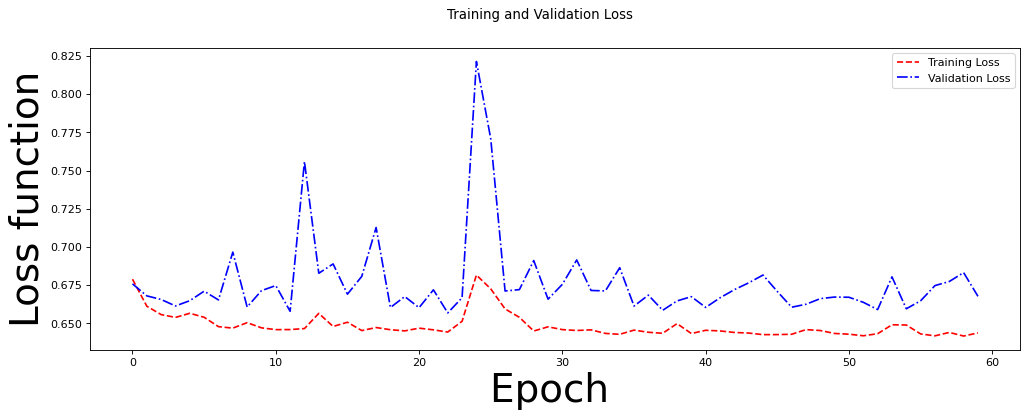

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

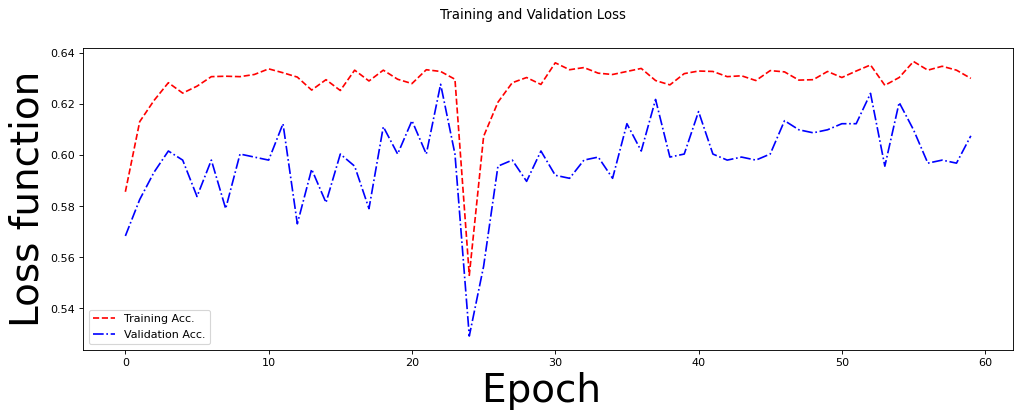

Test Accuracy : 0.6238095238095238
col_0    0    1
row_0          
0      289  135
1      181  235


<Figure size 432x288 with 0 Axes>

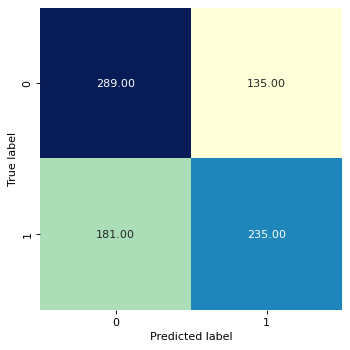

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model02
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 31, 55, 15)        150       
_________________________________________________________________
activation_5 (Activation)    (None, 31, 55, 15)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 31, 55, 15)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25575)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 57)                1457832   
_________________________________________________________________
activation_6 (Activation)    (None, 57)                0         
_______________________________________

Epoch 48/60
24/24 [==============================] - 1s 31ms/step - loss: 0.6438 - accuracy: 0.6325 - val_loss: 0.6603 - val_accuracy: 0.6112
Epoch 49/60
24/24 [==============================] - 1s 38ms/step - loss: 0.6526 - accuracy: 0.6211 - val_loss: 0.6716 - val_accuracy: 0.5933
Epoch 50/60
24/24 [==============================] - 1s 38ms/step - loss: 0.6457 - accuracy: 0.6266 - val_loss: 0.6592 - val_accuracy: 0.6207
Epoch 51/60
24/24 [==============================] - 1s 35ms/step - loss: 0.6437 - accuracy: 0.6320 - val_loss: 0.6587 - val_accuracy: 0.6219
Epoch 52/60
24/24 [==============================] - 1s 37ms/step - loss: 0.6449 - accuracy: 0.6325 - val_loss: 0.6724 - val_accuracy: 0.5957
Epoch 53/60
24/24 [==============================] - 1s 40ms/step - loss: 0.6437 - accuracy: 0.6347 - val_loss: 0.6780 - val_accuracy: 0.5945
Epoch 54/60
24/24 [==============================] - 1s 35ms/step - loss: 0.6479 - accuracy: 0.6278 - val_loss: 0.6742 - val_accuracy: 0.5922
Epoch 

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


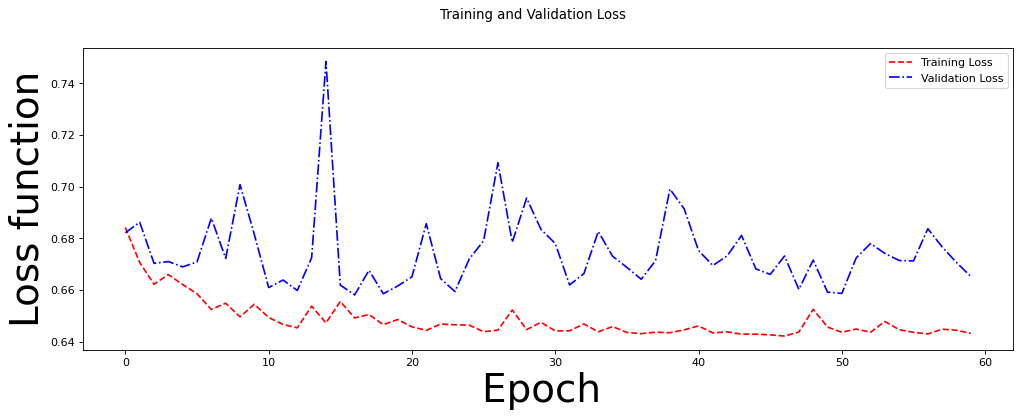

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

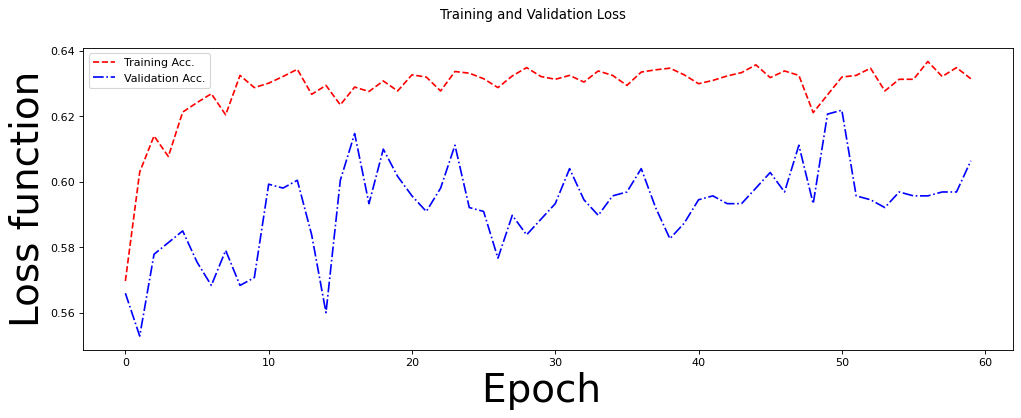

Test Accuracy : 0.6214285714285714
col_0    0    1
row_0          
0      283  141
1      177  239


<Figure size 432x288 with 0 Axes>

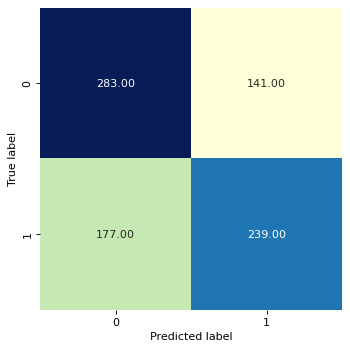

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model03
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 31, 55, 15)        150       
_________________________________________________________________
activation_8 (Activation)    (None, 31, 55, 15)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25575)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 51152     
_________________________________________________________________
activation_9 (Activation)    (None, 2)                 0         
Total params: 51,302
Trainable params: 51,302
Non-trainable params: 0
_________________________________________________________________
Val labeltab spread: [850. 832.]
Ep

Epoch 51/60
24/24 [==============================] - 0s 20ms/step - loss: 0.6460 - accuracy: 0.6323 - val_loss: 0.6640 - val_accuracy: 0.5993
Epoch 52/60
24/24 [==============================] - 1s 22ms/step - loss: 0.6475 - accuracy: 0.6364 - val_loss: 0.6691 - val_accuracy: 0.5933
Epoch 53/60
24/24 [==============================] - 0s 20ms/step - loss: 0.6460 - accuracy: 0.6303 - val_loss: 0.6751 - val_accuracy: 0.5910
Epoch 54/60
24/24 [==============================] - 0s 20ms/step - loss: 0.6462 - accuracy: 0.6320 - val_loss: 0.6722 - val_accuracy: 0.5922
Epoch 55/60
24/24 [==============================] - 0s 19ms/step - loss: 0.6454 - accuracy: 0.6317 - val_loss: 0.6602 - val_accuracy: 0.6029
Epoch 56/60
24/24 [==============================] - 0s 20ms/step - loss: 0.6500 - accuracy: 0.6289 - val_loss: 0.6794 - val_accuracy: 0.5874
Epoch 57/60
24/24 [==============================] - 0s 19ms/step - loss: 0.6459 - accuracy: 0.6308 - val_loss: 0.6693 - val_accuracy: 0.5933
Epoch 

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


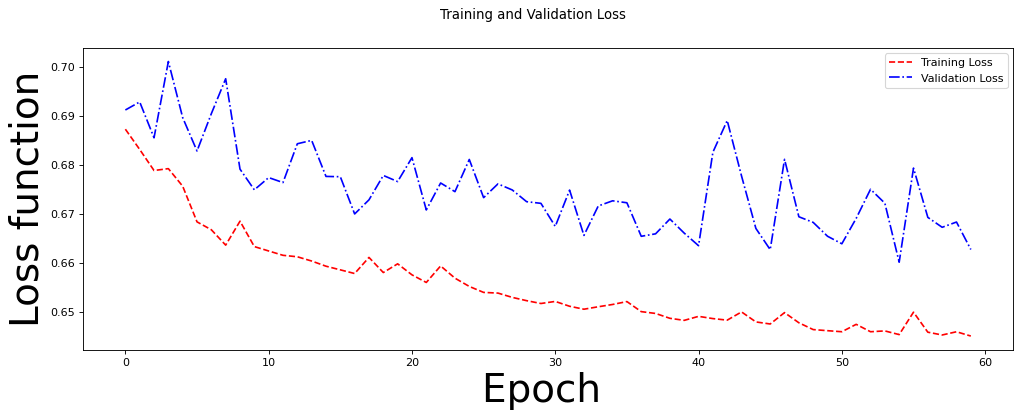

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

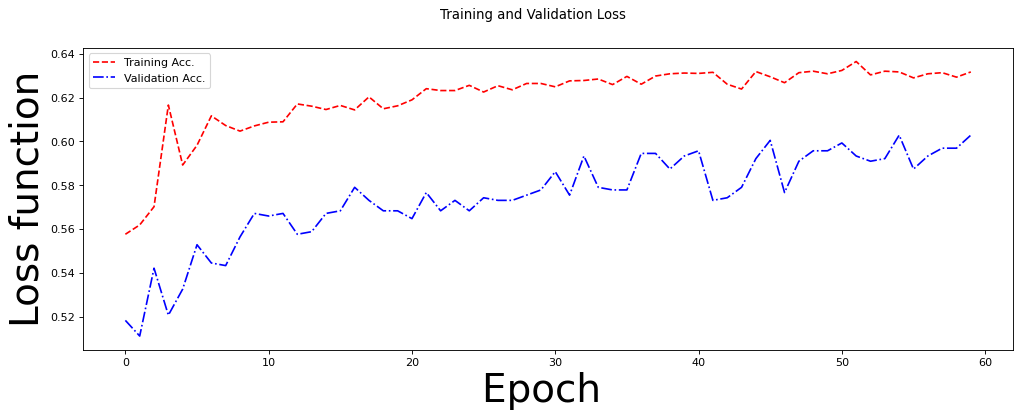

Test Accuracy : 0.6285714285714286
col_0    0    1
row_0          
0      299  125
1      187  229


<Figure size 432x288 with 0 Axes>

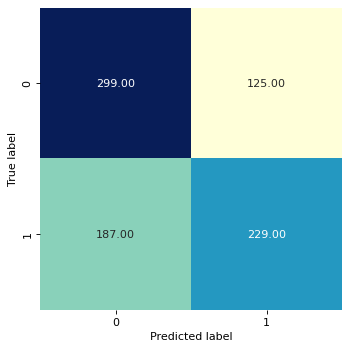

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

ModelNamesLs2=["model00","model01","model02","model03"]

ModelsLs2=[]  #BundleLs
BundleLs2=[TSdsp1]
BigResuDF={"model":[],"bundle":[],"accu":[],"recall":[],"specif":[],"ppv":[],"npv":[]}
ResuLsAtt=["accu","recall","specif","ppv","npv"]
for iBund, Bund in enumerate(BundleLs2):
    
    for Mo in ModelNamesLs2:
    #    NewSequentialModelazos2D(self;; BundleObj,modelname,nfiltLs,\
    #nbinsLs,nstrideLs,npoolLs,batchsize=20,epochs=15,learningR=0.01):
    
        ModObj=NewSequentialModelazos2D(Bund,Mo,[15],[3],[1],[2],batchsize=256,\
                                    epochs=60,learningR=0.0005)
        print("RUNNING BUNDLE ", Bund.name," with model ", ModObj.modelname)
        
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs2.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Bund.Test.labeltab,axis=-1))
        
        BigResuDF["model"].append(ModObj.modelname)
        BigResuDF["bundle"].append(Bund.name)
        for key in ResuLsAtt:
            BigResuDF[key].append(ModObj.results[key] )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3981097587785676286
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1899533120763430104
physical_device_desc: "device: XLA_CPU device"
]
Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model00
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 51, 128)       6400      
_________________________________________________________________
activation_10 (Activation)   (None, 27, 51, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 176256)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 352514    
___________________

12/12 [==============================] - 4s 359ms/step - loss: 0.6604 - accuracy: 0.6157 - val_loss: 0.6815 - val_accuracy: 0.5672
Epoch 49/120
12/12 [==============================] - 4s 364ms/step - loss: 0.6605 - accuracy: 0.6161 - val_loss: 0.6823 - val_accuracy: 0.5660
Epoch 50/120
12/12 [==============================] - 4s 363ms/step - loss: 0.6603 - accuracy: 0.6137 - val_loss: 0.6797 - val_accuracy: 0.5636
Epoch 51/120
12/12 [==============================] - 4s 370ms/step - loss: 0.6603 - accuracy: 0.6176 - val_loss: 0.6807 - val_accuracy: 0.5660
Epoch 52/120
12/12 [==============================] - 4s 365ms/step - loss: 0.6608 - accuracy: 0.6121 - val_loss: 0.6780 - val_accuracy: 0.5660
Epoch 53/120
12/12 [==============================] - 5s 376ms/step - loss: 0.6605 - accuracy: 0.6211 - val_loss: 0.6851 - val_accuracy: 0.5612
Epoch 54/120
12/12 [==============================] - 5s 382ms/step - loss: 0.6603 - accuracy: 0.6106 - val_loss: 0.6776 - val_accuracy: 0.5672
Epoch

Epoch 105/120
12/12 [==============================] - 4s 370ms/step - loss: 0.6562 - accuracy: 0.6191 - val_loss: 0.6796 - val_accuracy: 0.5707
Epoch 106/120
12/12 [==============================] - 4s 362ms/step - loss: 0.6562 - accuracy: 0.6230 - val_loss: 0.6831 - val_accuracy: 0.5660
Epoch 107/120
12/12 [==============================] - 5s 377ms/step - loss: 0.6562 - accuracy: 0.6159 - val_loss: 0.6775 - val_accuracy: 0.5719
Epoch 108/120
12/12 [==============================] - 4s 370ms/step - loss: 0.6563 - accuracy: 0.6233 - val_loss: 0.6818 - val_accuracy: 0.5696
Epoch 109/120
12/12 [==============================] - 5s 377ms/step - loss: 0.6563 - accuracy: 0.6193 - val_loss: 0.6739 - val_accuracy: 0.5767
Epoch 110/120
12/12 [==============================] - 5s 379ms/step - loss: 0.6567 - accuracy: 0.6233 - val_loss: 0.6820 - val_accuracy: 0.5684
Epoch 111/120
12/12 [==============================] - 5s 377ms/step - loss: 0.6557 - accuracy: 0.6184 - val_loss: 0.6765 - val_ac

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


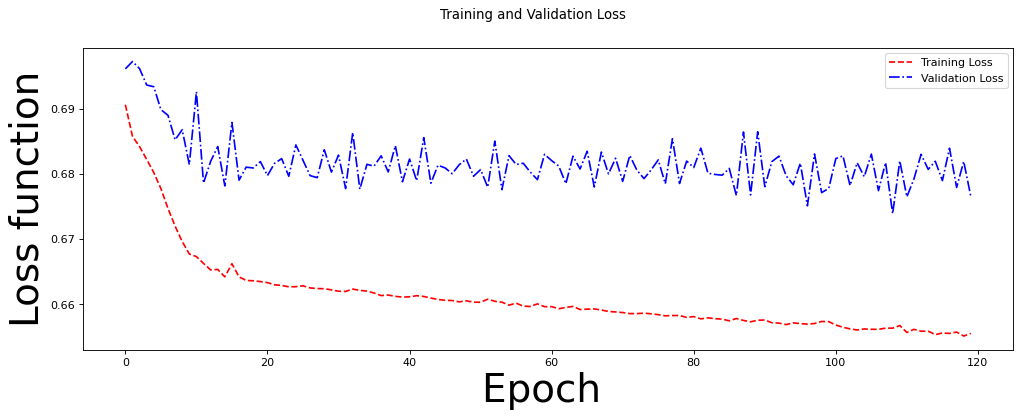

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

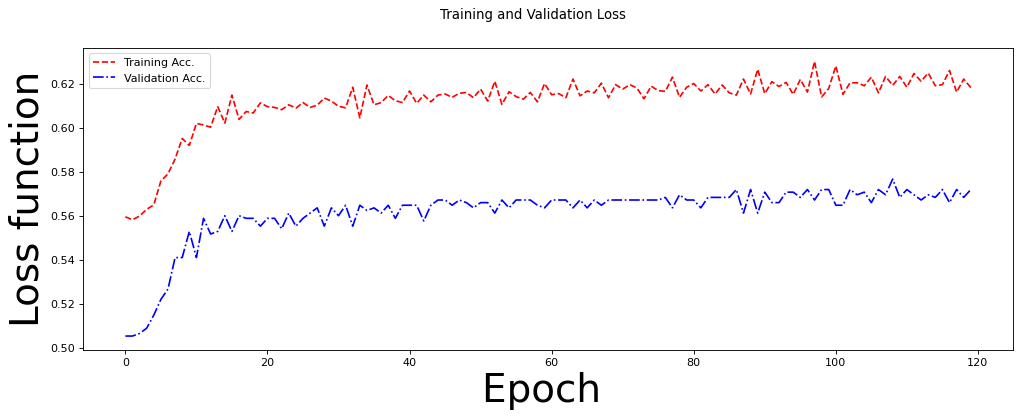

Test Accuracy : 0.6071428571428571
col_0    0    1
row_0          
0      358   66
1      264  152


<Figure size 432x288 with 0 Axes>

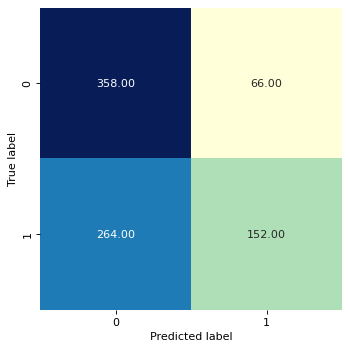

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model01
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 27, 51, 128)       6400      
_________________________________________________________________
activation_12 (Activation)   (None, 27, 51, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 49, 15)        17295     
_________________________________________________________________
activation_13 (Activation)   (None, 25, 49, 15)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 47, 15)        2040      
_________________________________________________________________
activation_14 (Activation)   (None, 23, 47, 15)        0         
_______________________________________

12/12 [==============================] - 13s 1s/step - loss: 0.6466 - accuracy: 0.6349 - val_loss: 0.6744 - val_accuracy: 0.6029
Epoch 46/120
12/12 [==============================] - 13s 1s/step - loss: 0.6466 - accuracy: 0.6361 - val_loss: 0.6711 - val_accuracy: 0.6017
Epoch 47/120
12/12 [==============================] - 13s 1s/step - loss: 0.6458 - accuracy: 0.6332 - val_loss: 0.6746 - val_accuracy: 0.6029
Epoch 48/120
12/12 [==============================] - 13s 1s/step - loss: 0.6461 - accuracy: 0.6344 - val_loss: 0.6752 - val_accuracy: 0.6029
Epoch 49/120
12/12 [==============================] - 13s 1s/step - loss: 0.6451 - accuracy: 0.6347 - val_loss: 0.6598 - val_accuracy: 0.6100
Epoch 50/120
12/12 [==============================] - 13s 1s/step - loss: 0.6482 - accuracy: 0.6274 - val_loss: 0.6643 - val_accuracy: 0.6040
Epoch 51/120
12/12 [==============================] - 13s 1s/step - loss: 0.6452 - accuracy: 0.6340 - val_loss: 0.6945 - val_accuracy: 0.5874
Epoch 52/120
12/12 

Epoch 103/120
12/12 [==============================] - 12s 1s/step - loss: 0.6444 - accuracy: 0.6364 - val_loss: 0.6670 - val_accuracy: 0.6040
Epoch 104/120
12/12 [==============================] - 12s 1s/step - loss: 0.6448 - accuracy: 0.6317 - val_loss: 0.6760 - val_accuracy: 0.6005
Epoch 105/120
12/12 [==============================] - 13s 1s/step - loss: 0.6450 - accuracy: 0.6342 - val_loss: 0.6656 - val_accuracy: 0.6029
Epoch 106/120
12/12 [==============================] - 12s 1s/step - loss: 0.6444 - accuracy: 0.6332 - val_loss: 0.6708 - val_accuracy: 0.5993
Epoch 107/120
12/12 [==============================] - 12s 1s/step - loss: 0.6441 - accuracy: 0.6344 - val_loss: 0.6683 - val_accuracy: 0.6017
Epoch 108/120
12/12 [==============================] - 12s 1s/step - loss: 0.6443 - accuracy: 0.6354 - val_loss: 0.6662 - val_accuracy: 0.6052
Epoch 109/120
12/12 [==============================] - 12s 1s/step - loss: 0.6441 - accuracy: 0.6334 - val_loss: 0.6732 - val_accuracy: 0.5981

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


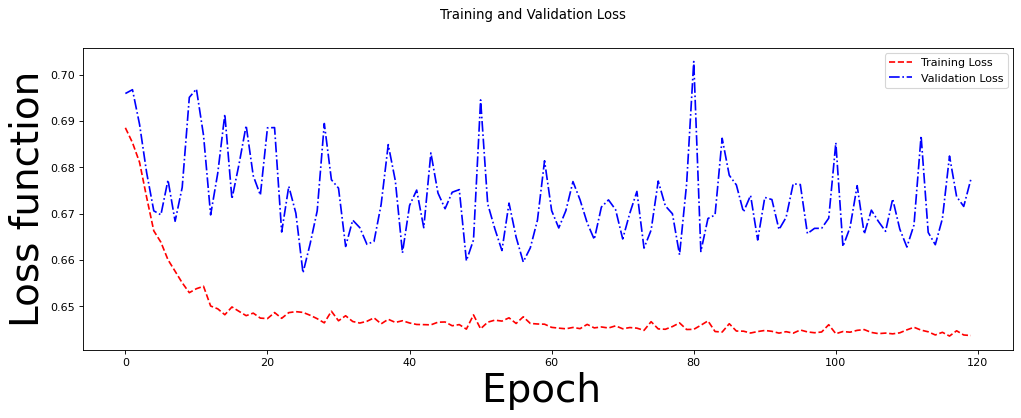

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

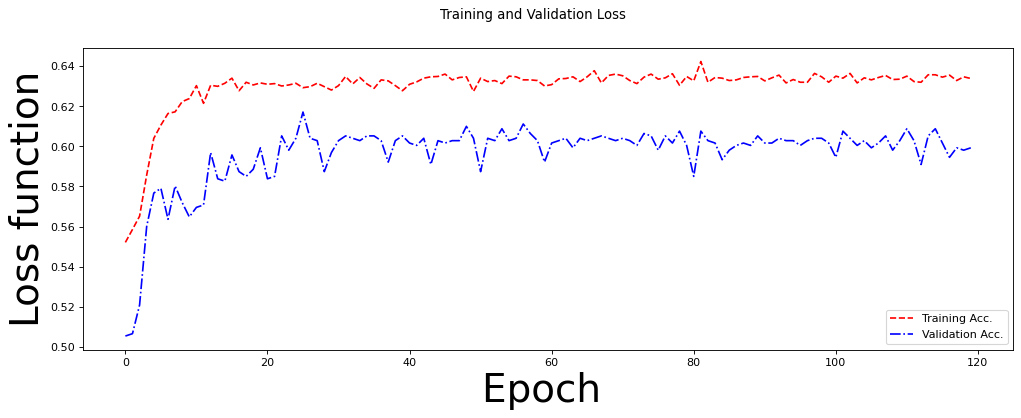

Test Accuracy : 0.6261904761904762
col_0    0    1
row_0          
0      314  110
1      204  212


<Figure size 432x288 with 0 Axes>

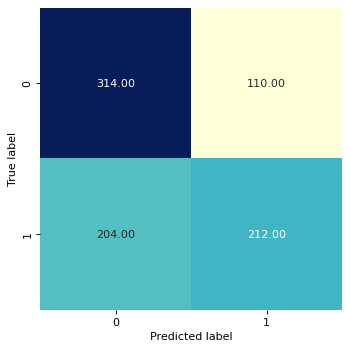

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model02
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 27, 51, 128)       6400      
_________________________________________________________________
activation_17 (Activation)   (None, 27, 51, 128)       0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 27, 51, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 49, 15)        17295     
_________________________________________________________________
activation_18 (Activation)   (None, 25, 49, 15)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 47, 15)        2040      
_______________________________________

12/12 [==============================] - 14s 1s/step - loss: 0.6472 - accuracy: 0.6328 - val_loss: 0.6777 - val_accuracy: 0.5981
Epoch 43/120
12/12 [==============================] - 14s 1s/step - loss: 0.6479 - accuracy: 0.6310 - val_loss: 0.6788 - val_accuracy: 0.5981
Epoch 44/120
12/12 [==============================] - 14s 1s/step - loss: 0.6472 - accuracy: 0.6315 - val_loss: 0.6704 - val_accuracy: 0.6029
Epoch 45/120
12/12 [==============================] - 14s 1s/step - loss: 0.6467 - accuracy: 0.6312 - val_loss: 0.6752 - val_accuracy: 0.6029
Epoch 46/120
12/12 [==============================] - 14s 1s/step - loss: 0.6469 - accuracy: 0.6295 - val_loss: 0.6736 - val_accuracy: 0.6005
Epoch 47/120
12/12 [==============================] - 14s 1s/step - loss: 0.6468 - accuracy: 0.6328 - val_loss: 0.6682 - val_accuracy: 0.6052
Epoch 48/120
12/12 [==============================] - 14s 1s/step - loss: 0.6467 - accuracy: 0.6313 - val_loss: 0.6652 - val_accuracy: 0.6052
Epoch 49/120
12/12 

Epoch 100/120
12/12 [==============================] - 14s 1s/step - loss: 0.6451 - accuracy: 0.6317 - val_loss: 0.6794 - val_accuracy: 0.5933
Epoch 101/120
12/12 [==============================] - 14s 1s/step - loss: 0.6451 - accuracy: 0.6322 - val_loss: 0.6863 - val_accuracy: 0.5898
Epoch 102/120
12/12 [==============================] - 14s 1s/step - loss: 0.6450 - accuracy: 0.6323 - val_loss: 0.6617 - val_accuracy: 0.6076
Epoch 103/120
12/12 [==============================] - 14s 1s/step - loss: 0.6453 - accuracy: 0.6310 - val_loss: 0.6686 - val_accuracy: 0.6029
Epoch 104/120
12/12 [==============================] - 14s 1s/step - loss: 0.6454 - accuracy: 0.6328 - val_loss: 0.6736 - val_accuracy: 0.5993
Epoch 105/120
12/12 [==============================] - 14s 1s/step - loss: 0.6445 - accuracy: 0.6339 - val_loss: 0.6689 - val_accuracy: 0.6017
Epoch 106/120
12/12 [==============================] - 14s 1s/step - loss: 0.6448 - accuracy: 0.6335 - val_loss: 0.6703 - val_accuracy: 0.6017

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


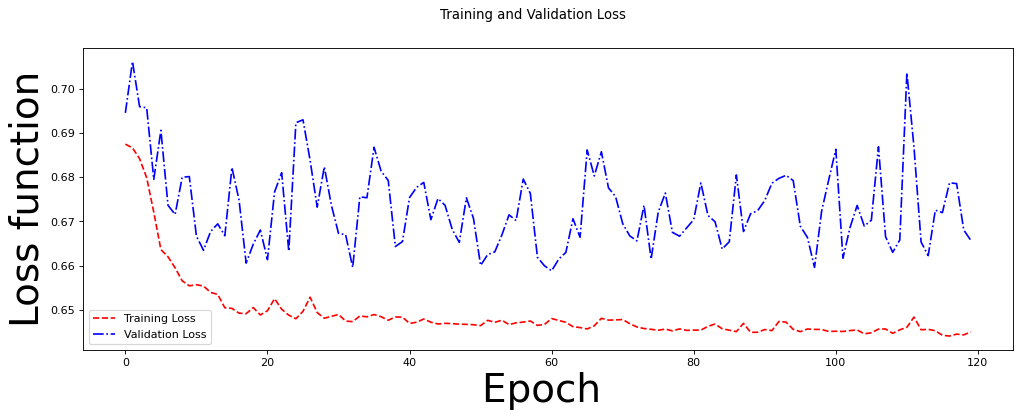

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

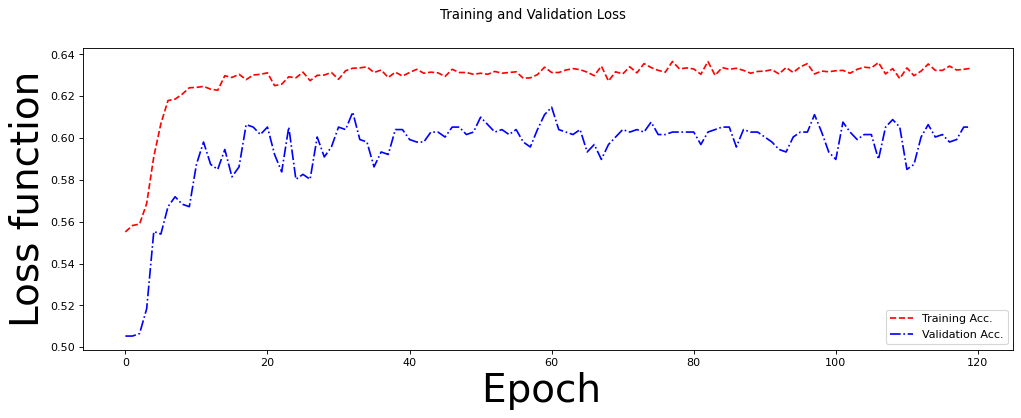

Test Accuracy : 0.6190476190476191
col_0    0    1
row_0          
0      280  144
1      176  240


<Figure size 432x288 with 0 Axes>

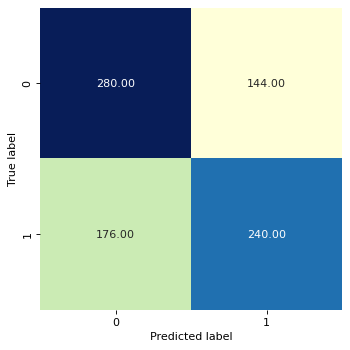

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp1  with model  model03
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 27, 51, 128)       6400      
_________________________________________________________________
activation_23 (Activation)   (None, 27, 51, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 25, 49, 15)        17295     
_________________________________________________________________
activation_24 (Activation)   (None, 25, 49, 15)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 47, 15)        2040      
_________________________________________________________________
activation_25 (Activation)   (None, 23, 47, 15)        0         
_______________________________________

12/12 [==============================] - 13s 1s/step - loss: 0.6483 - accuracy: 0.6312 - val_loss: 0.6832 - val_accuracy: 0.5910
Epoch 46/120
12/12 [==============================] - 13s 1s/step - loss: 0.6486 - accuracy: 0.6267 - val_loss: 0.6627 - val_accuracy: 0.6040
Epoch 47/120
12/12 [==============================] - 13s 1s/step - loss: 0.6484 - accuracy: 0.6298 - val_loss: 0.6677 - val_accuracy: 0.6040
Epoch 48/120
12/12 [==============================] - 13s 1s/step - loss: 0.6479 - accuracy: 0.6312 - val_loss: 0.6682 - val_accuracy: 0.6040
Epoch 49/120
12/12 [==============================] - 13s 1s/step - loss: 0.6475 - accuracy: 0.6325 - val_loss: 0.6805 - val_accuracy: 0.5922
Epoch 50/120
12/12 [==============================] - 13s 1s/step - loss: 0.6498 - accuracy: 0.6305 - val_loss: 0.6820 - val_accuracy: 0.5874
Epoch 51/120
12/12 [==============================] - 13s 1s/step - loss: 0.6500 - accuracy: 0.6291 - val_loss: 0.6686 - val_accuracy: 0.6017
Epoch 52/120
12/12 

Epoch 103/120
12/12 [==============================] - 13s 1s/step - loss: 0.6479 - accuracy: 0.6305 - val_loss: 0.6658 - val_accuracy: 0.6064
Epoch 104/120
12/12 [==============================] - 13s 1s/step - loss: 0.6479 - accuracy: 0.6293 - val_loss: 0.6612 - val_accuracy: 0.6064
Epoch 105/120
12/12 [==============================] - 13s 1s/step - loss: 0.6471 - accuracy: 0.6293 - val_loss: 0.6761 - val_accuracy: 0.5969
Epoch 106/120
12/12 [==============================] - 13s 1s/step - loss: 0.6463 - accuracy: 0.6335 - val_loss: 0.6638 - val_accuracy: 0.6029
Epoch 107/120
12/12 [==============================] - 13s 1s/step - loss: 0.6478 - accuracy: 0.6305 - val_loss: 0.6851 - val_accuracy: 0.5898
Epoch 108/120
12/12 [==============================] - 13s 1s/step - loss: 0.6494 - accuracy: 0.6288 - val_loss: 0.6753 - val_accuracy: 0.5933
Epoch 109/120
12/12 [==============================] - 13s 1s/step - loss: 0.6484 - accuracy: 0.6339 - val_loss: 0.6625 - val_accuracy: 0.6040

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


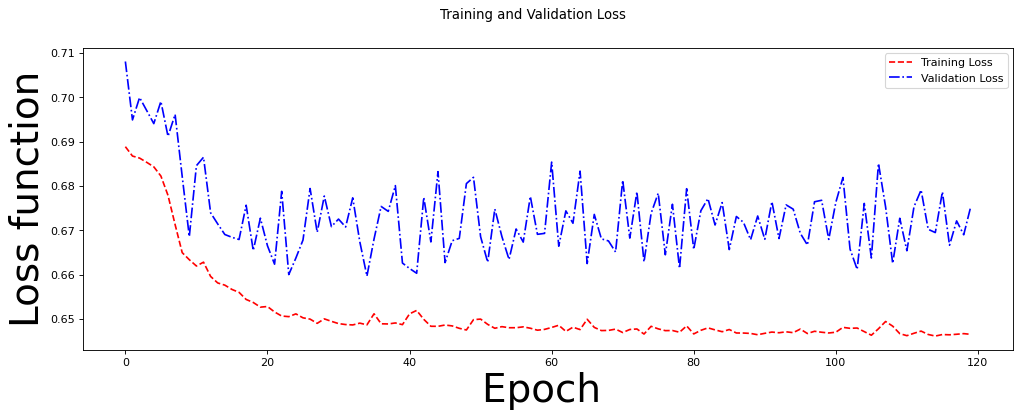

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

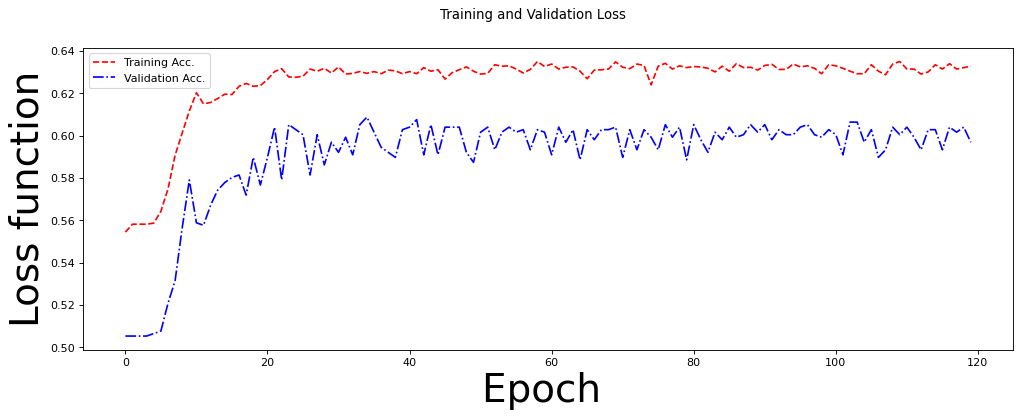

Test Accuracy : 0.6095238095238096
col_0    0    1
row_0          
0      303  121
1      207  209


<Figure size 432x288 with 0 Axes>

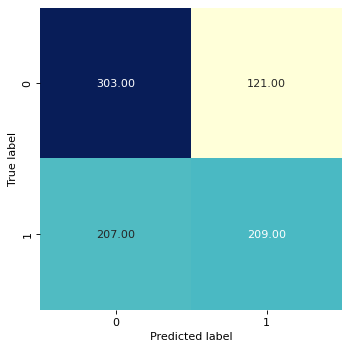

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp2  with model  model00
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 21, 128)       6400      
_________________________________________________________________
activation_27 (Activation)   (None, 27, 21, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 72576)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 145154    
_________________________________________________________________
activation_28 (Activation)   (None, 2)                 0         
Total params: 151,554
Trainable params: 151,554
Non-trainable params: 0
_________________________________________________________________
Val labeltab spread: [850. 832.]


12/12 [==============================] - 2s 143ms/step - loss: 0.6652 - accuracy: 0.6011 - val_loss: 0.6784 - val_accuracy: 0.5624
Epoch 51/120
12/12 [==============================] - 2s 148ms/step - loss: 0.6648 - accuracy: 0.6098 - val_loss: 0.6765 - val_accuracy: 0.5684
Epoch 52/120
12/12 [==============================] - 2s 144ms/step - loss: 0.6645 - accuracy: 0.6071 - val_loss: 0.6774 - val_accuracy: 0.5672
Epoch 53/120
12/12 [==============================] - 2s 146ms/step - loss: 0.6648 - accuracy: 0.6043 - val_loss: 0.6770 - val_accuracy: 0.5672
Epoch 54/120
12/12 [==============================] - 2s 147ms/step - loss: 0.6646 - accuracy: 0.6049 - val_loss: 0.6772 - val_accuracy: 0.5672
Epoch 55/120
12/12 [==============================] - 2s 144ms/step - loss: 0.6648 - accuracy: 0.6106 - val_loss: 0.6770 - val_accuracy: 0.5672
Epoch 56/120
12/12 [==============================] - 2s 142ms/step - loss: 0.6642 - accuracy: 0.6040 - val_loss: 0.6788 - val_accuracy: 0.5600
Epoch

Epoch 107/120
12/12 [==============================] - 2s 149ms/step - loss: 0.6613 - accuracy: 0.6116 - val_loss: 0.6780 - val_accuracy: 0.5707
Epoch 108/120
12/12 [==============================] - 2s 142ms/step - loss: 0.6618 - accuracy: 0.6172 - val_loss: 0.6751 - val_accuracy: 0.5743
Epoch 109/120
12/12 [==============================] - 2s 144ms/step - loss: 0.6614 - accuracy: 0.6084 - val_loss: 0.6780 - val_accuracy: 0.5707
Epoch 110/120
12/12 [==============================] - 2s 142ms/step - loss: 0.6612 - accuracy: 0.6144 - val_loss: 0.6757 - val_accuracy: 0.5731
Epoch 111/120
12/12 [==============================] - 2s 146ms/step - loss: 0.6609 - accuracy: 0.6135 - val_loss: 0.6767 - val_accuracy: 0.5731
Epoch 112/120
12/12 [==============================] - 2s 144ms/step - loss: 0.6612 - accuracy: 0.6076 - val_loss: 0.6750 - val_accuracy: 0.5743
Epoch 113/120
12/12 [==============================] - 2s 148ms/step - loss: 0.6609 - accuracy: 0.6183 - val_loss: 0.6744 - val_ac

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


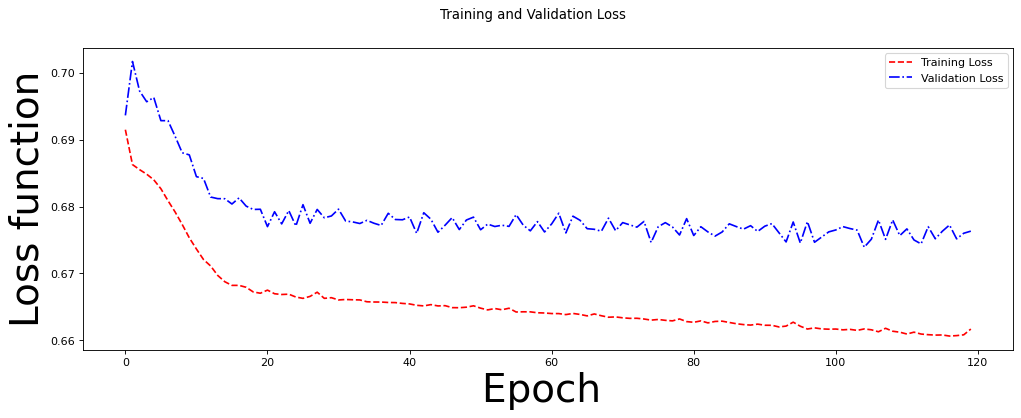

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

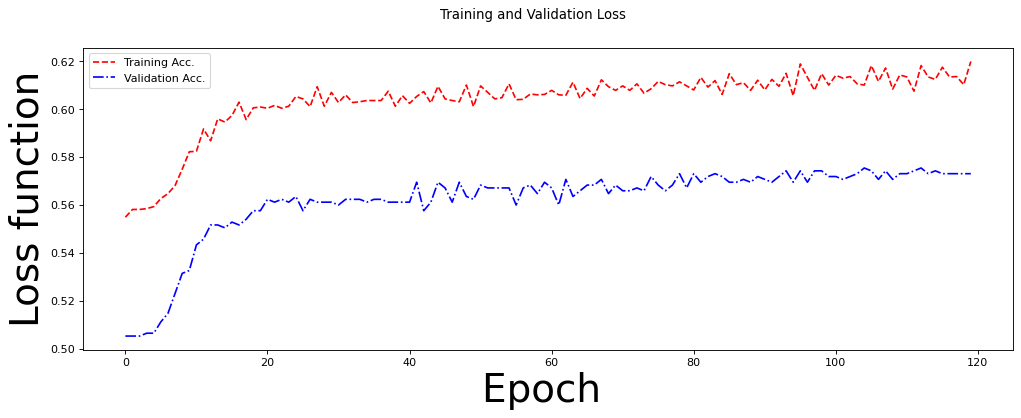

Test Accuracy : 0.5976190476190476
col_0    0    1
row_0          
0      371   53
1      285  131


<Figure size 432x288 with 0 Axes>

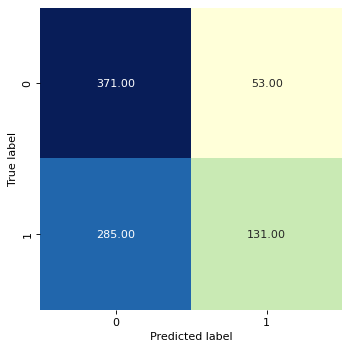

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp2  with model  model01
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 27, 21, 128)       6400      
_________________________________________________________________
activation_29 (Activation)   (None, 27, 21, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 25, 19, 15)        17295     
_________________________________________________________________
activation_30 (Activation)   (None, 25, 19, 15)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 23, 17, 15)        2040      
_________________________________________________________________
activation_31 (Activation)   (None, 23, 17, 15)        0         
_______________________________________

12/12 [==============================] - 5s 397ms/step - loss: 0.6495 - accuracy: 0.6298 - val_loss: 0.6561 - val_accuracy: 0.6195
Epoch 45/120
12/12 [==============================] - 5s 394ms/step - loss: 0.6489 - accuracy: 0.6330 - val_loss: 0.6563 - val_accuracy: 0.6195
Epoch 46/120
12/12 [==============================] - 5s 396ms/step - loss: 0.6488 - accuracy: 0.6289 - val_loss: 0.6661 - val_accuracy: 0.6100
Epoch 47/120
12/12 [==============================] - 5s 395ms/step - loss: 0.6492 - accuracy: 0.6295 - val_loss: 0.6626 - val_accuracy: 0.6159
Epoch 48/120
12/12 [==============================] - 5s 397ms/step - loss: 0.6483 - accuracy: 0.6337 - val_loss: 0.6589 - val_accuracy: 0.6219
Epoch 49/120
12/12 [==============================] - 5s 398ms/step - loss: 0.6485 - accuracy: 0.6335 - val_loss: 0.6566 - val_accuracy: 0.6219
Epoch 50/120
12/12 [==============================] - 5s 396ms/step - loss: 0.6492 - accuracy: 0.6312 - val_loss: 0.6554 - val_accuracy: 0.6183
Epoch

Epoch 101/120
12/12 [==============================] - 5s 394ms/step - loss: 0.6470 - accuracy: 0.6330 - val_loss: 0.6627 - val_accuracy: 0.6136
Epoch 102/120
12/12 [==============================] - 5s 396ms/step - loss: 0.6465 - accuracy: 0.6362 - val_loss: 0.6548 - val_accuracy: 0.6183
Epoch 103/120
12/12 [==============================] - 5s 398ms/step - loss: 0.6467 - accuracy: 0.6347 - val_loss: 0.6536 - val_accuracy: 0.6219
Epoch 104/120
12/12 [==============================] - 5s 396ms/step - loss: 0.6473 - accuracy: 0.6328 - val_loss: 0.6769 - val_accuracy: 0.6088
Epoch 105/120
12/12 [==============================] - 5s 397ms/step - loss: 0.6474 - accuracy: 0.6351 - val_loss: 0.6703 - val_accuracy: 0.6088
Epoch 106/120
12/12 [==============================] - 5s 397ms/step - loss: 0.6482 - accuracy: 0.6306 - val_loss: 0.6565 - val_accuracy: 0.6136
Epoch 107/120
12/12 [==============================] - 5s 399ms/step - loss: 0.6466 - accuracy: 0.6340 - val_loss: 0.6565 - val_ac

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


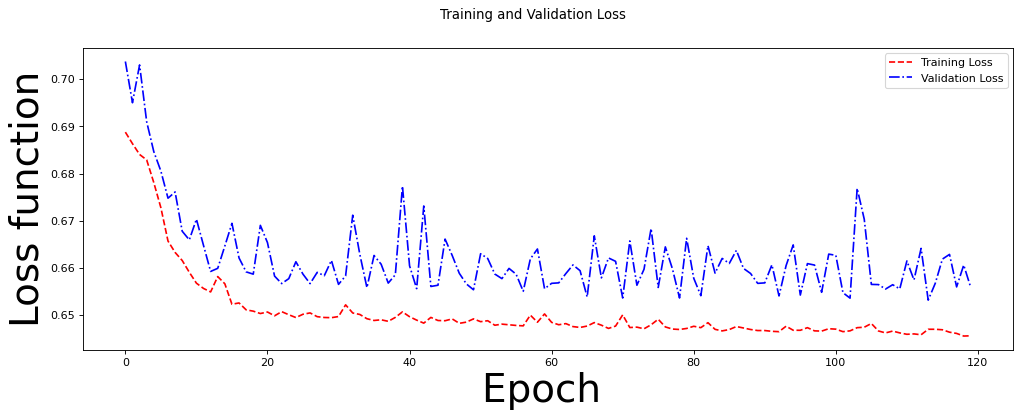

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

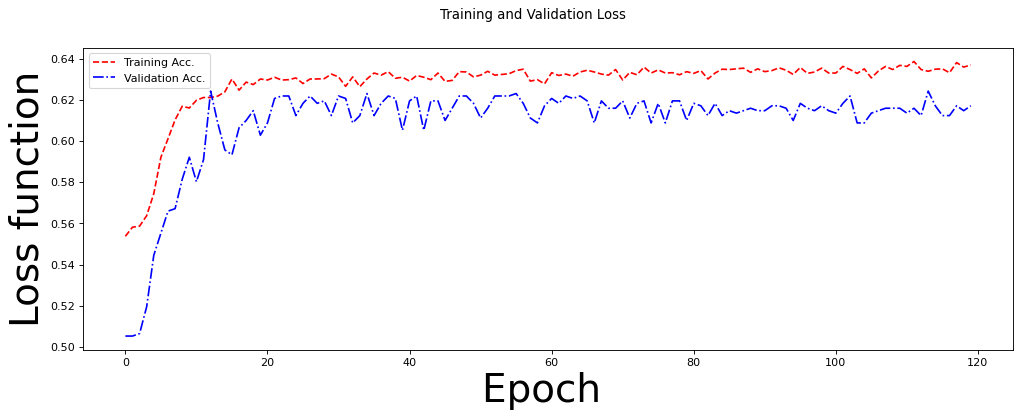

Test Accuracy : 0.6261904761904762
col_0    0    1
row_0          
0      297  127
1      187  229


<Figure size 432x288 with 0 Axes>

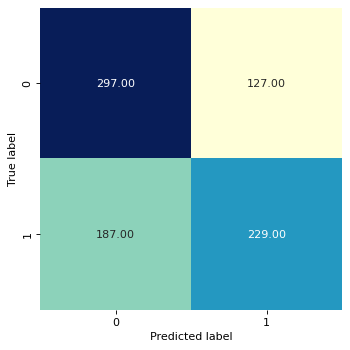

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp2  with model  model02
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 27, 21, 128)       6400      
_________________________________________________________________
activation_34 (Activation)   (None, 27, 21, 128)       0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 27, 21, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 25, 19, 15)        17295     
_________________________________________________________________
activation_35 (Activation)   (None, 25, 19, 15)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 23, 17, 15)        2040      
______________________________________

Epoch 42/120
12/12 [==============================] - 5s 458ms/step - loss: 0.6508 - accuracy: 0.6293 - val_loss: 0.6562 - val_accuracy: 0.6243
Epoch 43/120
12/12 [==============================] - 5s 456ms/step - loss: 0.6505 - accuracy: 0.6308 - val_loss: 0.6582 - val_accuracy: 0.6219
Epoch 44/120
12/12 [==============================] - 5s 454ms/step - loss: 0.6498 - accuracy: 0.6320 - val_loss: 0.6647 - val_accuracy: 0.6136
Epoch 45/120
12/12 [==============================] - 5s 456ms/step - loss: 0.6497 - accuracy: 0.6289 - val_loss: 0.6583 - val_accuracy: 0.6243
Epoch 46/120
12/12 [==============================] - 5s 455ms/step - loss: 0.6501 - accuracy: 0.6298 - val_loss: 0.6694 - val_accuracy: 0.6100
Epoch 47/120
12/12 [==============================] - 5s 452ms/step - loss: 0.6499 - accuracy: 0.6291 - val_loss: 0.6569 - val_accuracy: 0.6243
Epoch 48/120
12/12 [==============================] - 5s 453ms/step - loss: 0.6504 - accuracy: 0.6300 - val_loss: 0.6626 - val_accuracy:

Epoch 99/120
12/12 [==============================] - 5s 457ms/step - loss: 0.6481 - accuracy: 0.6323 - val_loss: 0.6574 - val_accuracy: 0.6207
Epoch 100/120
12/12 [==============================] - 5s 454ms/step - loss: 0.6487 - accuracy: 0.6323 - val_loss: 0.6613 - val_accuracy: 0.6147
Epoch 101/120
12/12 [==============================] - 5s 455ms/step - loss: 0.6479 - accuracy: 0.6305 - val_loss: 0.6627 - val_accuracy: 0.6112
Epoch 102/120
12/12 [==============================] - 5s 454ms/step - loss: 0.6477 - accuracy: 0.6317 - val_loss: 0.6583 - val_accuracy: 0.6207
Epoch 103/120
12/12 [==============================] - 5s 455ms/step - loss: 0.6474 - accuracy: 0.6323 - val_loss: 0.6594 - val_accuracy: 0.6207
Epoch 104/120
12/12 [==============================] - 5s 452ms/step - loss: 0.6477 - accuracy: 0.6340 - val_loss: 0.6721 - val_accuracy: 0.6064
Epoch 105/120
12/12 [==============================] - 5s 453ms/step - loss: 0.6488 - accuracy: 0.6335 - val_loss: 0.6554 - val_acc

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


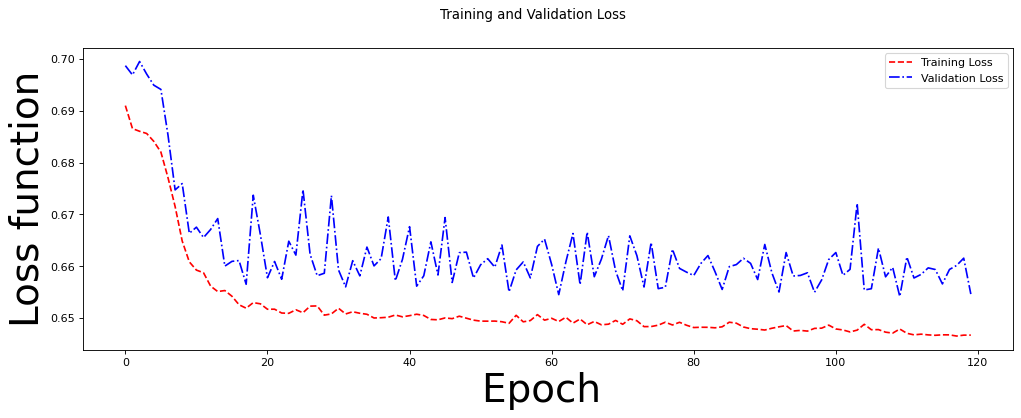

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

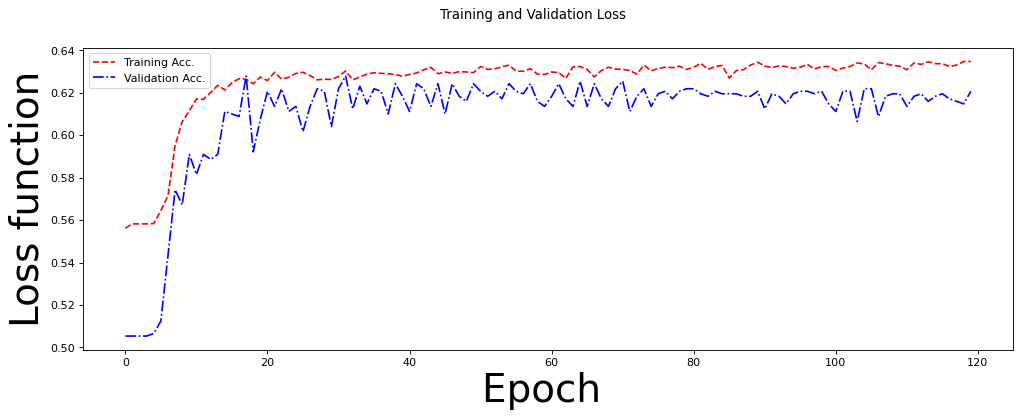

Test Accuracy : 0.6333333333333333
col_0    0    1
row_0          
0      290  134
1      174  242


<Figure size 432x288 with 0 Axes>

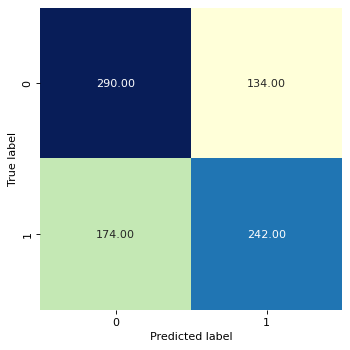

Train labeltab spread: [3290. 2604.]
RUNNING BUNDLE  TSdsp2  with model  model03
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 27, 21, 128)       6400      
_________________________________________________________________
activation_40 (Activation)   (None, 27, 21, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 25, 19, 15)        17295     
_________________________________________________________________
activation_41 (Activation)   (None, 25, 19, 15)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 23, 17, 15)        2040      
_________________________________________________________________
activation_42 (Activation)   (None, 23, 17, 15)        0         
______________________________________

12/12 [==============================] - 5s 423ms/step - loss: 0.6513 - accuracy: 0.6283 - val_loss: 0.6634 - val_accuracy: 0.6088
Epoch 45/120
12/12 [==============================] - 5s 421ms/step - loss: 0.6514 - accuracy: 0.6312 - val_loss: 0.6576 - val_accuracy: 0.6159
Epoch 46/120
12/12 [==============================] - 5s 420ms/step - loss: 0.6516 - accuracy: 0.6278 - val_loss: 0.6631 - val_accuracy: 0.6088
Epoch 47/120
12/12 [==============================] - 5s 421ms/step - loss: 0.6516 - accuracy: 0.6281 - val_loss: 0.6596 - val_accuracy: 0.6159
Epoch 48/120
12/12 [==============================] - 5s 419ms/step - loss: 0.6512 - accuracy: 0.6298 - val_loss: 0.6621 - val_accuracy: 0.6112
Epoch 49/120
12/12 [==============================] - 5s 417ms/step - loss: 0.6512 - accuracy: 0.6305 - val_loss: 0.6641 - val_accuracy: 0.6100
Epoch 50/120
12/12 [==============================] - 5s 419ms/step - loss: 0.6512 - accuracy: 0.6306 - val_loss: 0.6576 - val_accuracy: 0.6171
Epoch

Epoch 101/120
12/12 [==============================] - 5s 419ms/step - loss: 0.6505 - accuracy: 0.6301 - val_loss: 0.6595 - val_accuracy: 0.6171
Epoch 102/120
12/12 [==============================] - 5s 426ms/step - loss: 0.6495 - accuracy: 0.6308 - val_loss: 0.6639 - val_accuracy: 0.6124
Epoch 103/120
12/12 [==============================] - 5s 432ms/step - loss: 0.6496 - accuracy: 0.6300 - val_loss: 0.6600 - val_accuracy: 0.6159
Epoch 104/120
12/12 [==============================] - 5s 418ms/step - loss: 0.6489 - accuracy: 0.6345 - val_loss: 0.6624 - val_accuracy: 0.6147
Epoch 105/120
12/12 [==============================] - 5s 418ms/step - loss: 0.6495 - accuracy: 0.6301 - val_loss: 0.6572 - val_accuracy: 0.6207
Epoch 106/120
12/12 [==============================] - 5s 418ms/step - loss: 0.6489 - accuracy: 0.6306 - val_loss: 0.6633 - val_accuracy: 0.6124
Epoch 107/120
12/12 [==============================] - 5s 425ms/step - loss: 0.6492 - accuracy: 0.6325 - val_loss: 0.6573 - val_ac

<ipython-input-13-df8778f5a4ff>:173: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


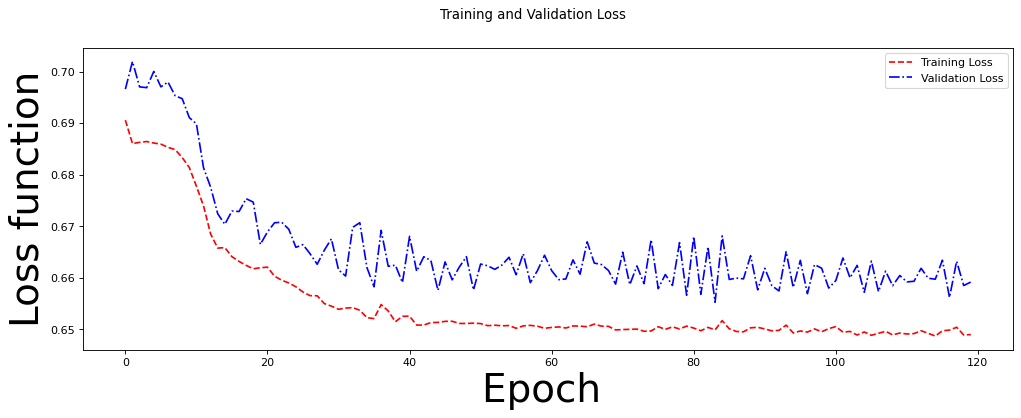

<ipython-input-13-df8778f5a4ff>:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax4=fig.add_subplot(111)


<Figure size 432x288 with 0 Axes>

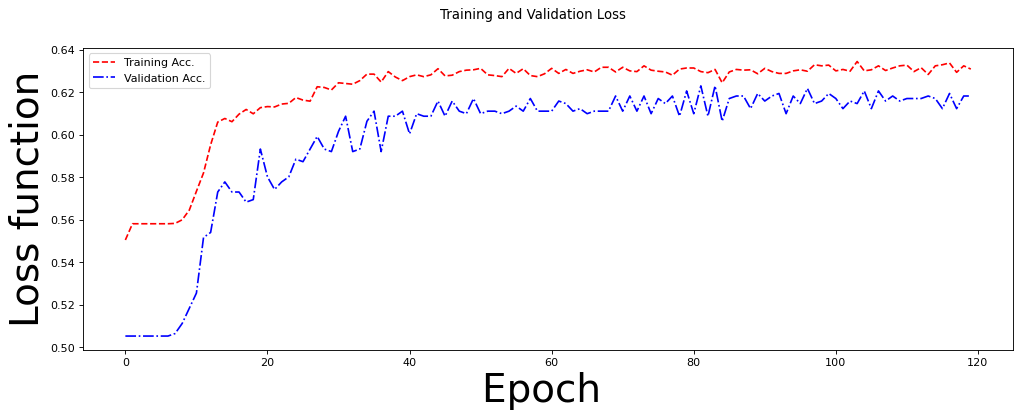

Test Accuracy : 0.6357142857142857
col_0    0    1
row_0          
0      308  116
1      190  226


<Figure size 432x288 with 0 Axes>

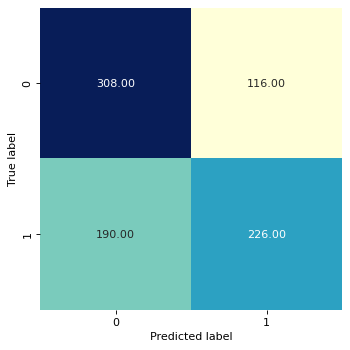

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
BundleLs=[TSdsp1,TSdsp2]#,TSdsp8,TSdsp16]
#BundleLs=[TSdsp4,TSdsp8,TSdsp16]
#BundleLs=[TSdsp4]
ModelNamesLs=["model00","model01","model02","model03"]#,"model02"]
#ModelNamesLs=["model00","model01"]
ModelsLs=[]  #BundleLs
for iBund, Bund in enumerate(BundleLs):
    
    for Mo in ModelNamesLs:
        
        ModObj=NewSequentialModelazos2D(Bund,Mo,[128,15],[7,3],[1,1],[2,2],batchsize=512,\
                                    epochs=120,learningR=0.0001)
        print("RUNNING BUNDLE ", Bund.name," with model ", ModObj.modelname)
        
        func="setup_"+Mo
        #model0,history0=make_and_run_model0(Gal,[16,12],[5,3],[2,2],batchsize=20)
        ModelsLs.append(ModObj)
        getattr(ModObj,func)()
        ModObj.run_model()
        ModObj.plot_history()
        ModObj.predict()
        ModObj.make_confusion_mat(np.argmax(Bund.Test.labeltab,axis=-1))
        
        BigResuDF["model"].append(ModObj.modelname)
        BigResuDF["bundle"].append(Bund.name)
        for key in ResuLsAtt:
            BigResuDF[key].append(ModObj.results[key] )

In [16]:
BigResuDF=pd.DataFrame(BigResuDF)
display(BigResuDF)

model  bundle      accu    recall    specif       ppv       npv
0   model00  TSdsp1  0.595238  0.326923  0.858491  0.693878  0.565217
1   model01  TSdsp1  0.623810  0.564904  0.681604  0.635135  0.614894
2   model02  TSdsp1  0.621429  0.574519  0.667453  0.628947  0.615217
3   model03  TSdsp1  0.628571  0.550481  0.705189  0.646893  0.615226
4   model00  TSdsp1  0.607143  0.365385  0.844340  0.697248  0.575563
5   model01  TSdsp1  0.626190  0.509615  0.740566  0.658385  0.606178
6   model02  TSdsp1  0.619048  0.576923  0.660377  0.625000  0.614035
7   model03  TSdsp1  0.609524  0.502404  0.714623  0.633333  0.594118
8   model00  TSdsp2  0.597619  0.314904  0.875000  0.711957  0.565549
9   model01  TSdsp2  0.626190  0.550481  0.700472  0.643258  0.613636
10  model02  TSdsp2  0.633333  0.581731  0.683962  0.643617  0.625000
11  model03  TSdsp2  0.635714  0.543269  0.726415  0.660819  0.618474